In [255]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import time 

# Problem 1: Digit Recognizer

In [256]:
# Loading the dataset
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

## Data exploration

In [257]:
# Print a random sample to visualise it
print(y[5])

8


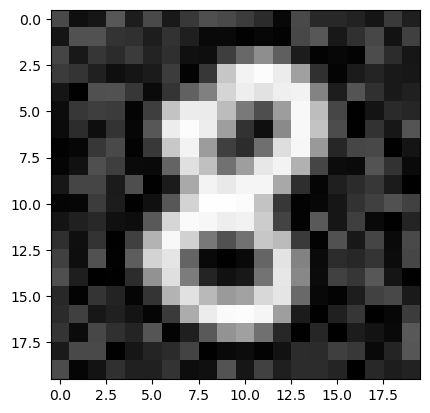

In [258]:
# Here we can see clearly that it is an 8
plt.imshow(X[5].reshape(20,20), vmin=0, vmax=255.0, cmap="gray")
plt.show()

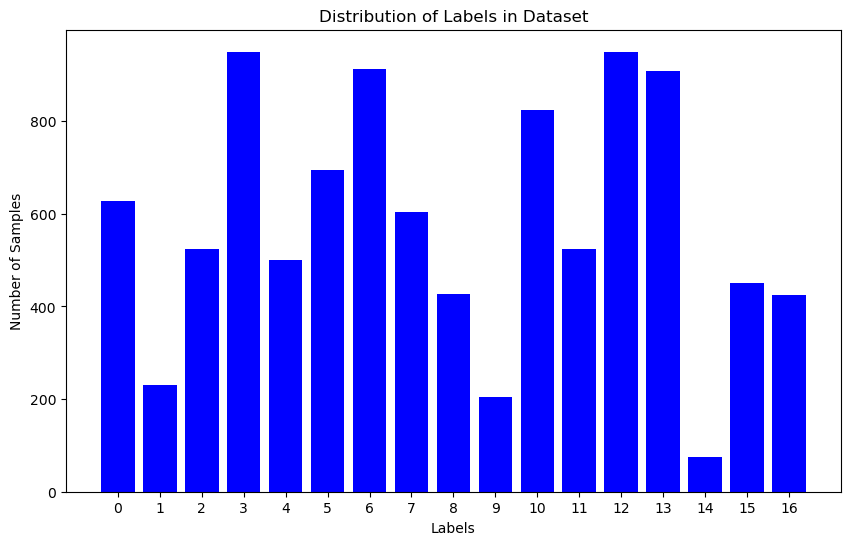

Highest count of classes:  950
Lowest count of classes:  74


In [259]:
# Visualizing the distribution of classes in the dataset

label_counts = Counter(y)
labels = list(label_counts.keys())
counts = list(label_counts.values())
sorted_labels_counts = sorted(zip(labels, counts), key=lambda x: x[0])
sorted_labels, sorted_counts = zip(*sorted_labels_counts)


plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in Dataset')
plt.xticks(sorted_labels)  
plt.show()

print("Highest count of classes: ", max(label_counts.values()))
print("Lowest count of classes: ", min(label_counts.values()))


Above we see that the classes has very different amount of samples. Class 14 has only 74, and class 3 has as as much as 950. This means that there is a imbalance in the dataset that we need to account for. Our approach will be to oversample our data so that we remove the imbalance.

The reason we chose to oversample is because this improves performance on minority classes.
We know that oversampling can lead to overfitting since we have more of the "same" data. Also with oversampling it increases computational cost for us to train and tune since it has more data to go through. But we think it is worth it, and we are choosing to use k-fold cross validation when we are tuning to account for overfitting risks.

## Data pre-processing

In [260]:
# For reproducability we set a seed
seed = 0
np.random.seed(seed)

In [261]:
#Split the data into test and (training and validation)
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, shuffle=True, stratify=y)
# We use stratify so that the distribution is equal in the test and the training + validation sets.


# We normalize so that whatever classifier we choose all features will contribute equally. (This is not needed for random forest, but it is for others.)
# Normalize the data to range from 0 to 1
X_train_val = X_train_val / 255.0
X_test = X_test / 255.0

# Oversample our data with Smote
smote = SMOTE(random_state=seed)
X_train_val, y_train_val = smote.fit_resample(X_train_val, y_train_val) 
# We only oversample the training and validation! Why? 
# Because if we oversampled the test-data we would make the test data unrealistic and not represntative of real world data.

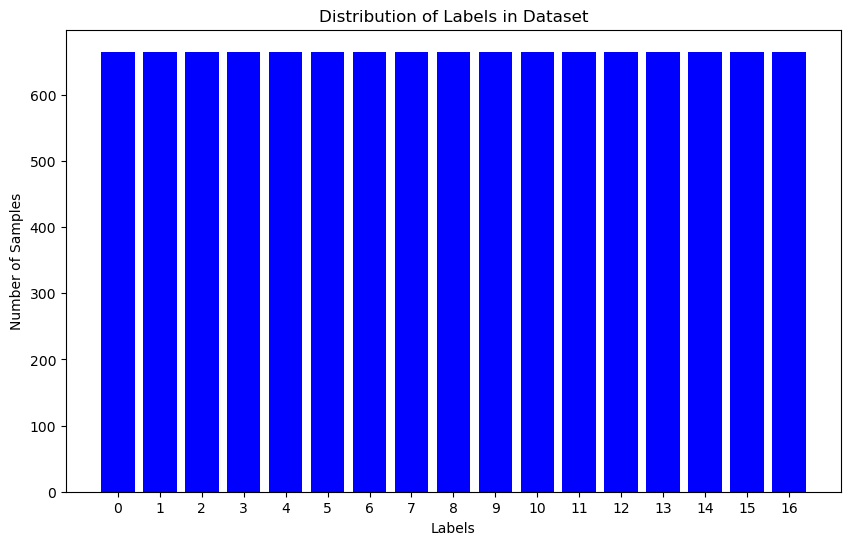

Highest count of classes:  665
Lowest count of classes:  665


In [262]:
# Visualizing the distribution of classes in the dataset now after oversampling
label_counts = Counter(y_train_val)
labels = list(label_counts.keys())
counts = list(label_counts.values())
sorted_labels_counts = sorted(zip(labels, counts), key=lambda x: x[0])
sorted_labels, sorted_counts = zip(*sorted_labels_counts)


plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in Dataset')
plt.xticks(sorted_labels)  
plt.show()

print("Highest count of classes: ", max(label_counts.values()))
print("Lowest count of classes: ", min(label_counts.values()))

After oversampling we see that the distribution has no imbalance.

# Random Forest classifier

In [263]:
rf = RandomForestClassifier(random_state=seed)

# Defining the hyperparameters we want to tune:
param_grid = {
    'n_estimators': [10,15,20,40,100],  # Number of trees in the forest
    'max_depth': [None, 10,15,20,30],  # Maximum depth of the trees
    'max_features': ['sqrt','log2'], # Number of features to consider for best split
    'criterion': ['entropy','gini'] # How to compute the information gain when splitting
}   

# param_grid = {
#     'n_estimators': [100],  # Number of trees in the forest
#     'max_depth': [20],  # Maximum depth of the trees
#     'max_features': ['sqrt'], # Number of features to consider for best split
#     'criterion': ['entropy'] # How to compute the information gain when splitting
# }   


grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, n_jobs=-1, verbose=0)
# Here we can use accruacy when tuning since we removed the imbalance

grid_search_rf.fit(X_train_val, y_train_val)

print("Best Hyperparameters:", grid_search_rf.best_params_)
print("Best Cross-Validation accuracy:", grid_search_rf.best_score_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Best Cross-Validation accuracy: 0.9473684210526315


# SVM


In [264]:
svm = SVC(random_state = seed)

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type to be used in the algorithm
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function ('poly')
}

# param_grid = {
#     'C': [10],  # Regularization parameter
#     'kernel': ['rbf'],  # Kernel type to be used in the algorithm
#     'gamma': ['scale'],  # Kernel coefficient
#     'degree': [2]  # Degree of the polynomial kernel function ('poly')
# }

grid_search_SVM = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           scoring='accuracy',          
                           cv=5, n_jobs=-1, verbose=0)
# Here we can use accruacy when tuning since we removed the imbalance


grid_search_SVM.fit(X_train_val, y_train_val)

print("Best Hyperparameters:", grid_search_SVM.best_params_)
print("Best Cross-Validation accuracy:", grid_search_SVM.best_score_)

Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation accuracy: 0.9701017249004865


### Choosing the best classifier:
Here our code chooses the classifier that had the best cross-validation accuracy.

In [265]:
# Evaluate the best model on the test set
if grid_search_SVM.best_score_ >= grid_search_rf.best_score_:
    best_model = grid_search_SVM.best_estimator_ # Get the SVM with the best parameters
    print("SVM: ")
else:
    best_model = grid_search_rf.best_estimator_
    print("Random forest: ")

# Here we use classification report so that we can see how well the classifier performs on each class
print(classification_report(y_test, best_model.predict(X_test)))

SVM: 
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       188
           1       0.89      0.96      0.92        69
           2       0.91      0.95      0.93       157
           3       0.94      0.95      0.95       285
           4       0.89      0.89      0.89       150
           5       0.90      0.93      0.92       209
           6       0.97      0.95      0.96       274
           7       0.95      0.95      0.95       182
           8       0.90      0.88      0.89       128
           9       0.93      0.89      0.91        61
          10       0.91      0.95      0.93       248
          11       0.91      0.79      0.85       158
          12       0.96      0.95      0.96       285
          13       0.89      0.93      0.91       273
          14       0.80      0.55      0.65        22
          15       0.84      0.83      0.84       135
          16       1.00      1.00      1.00       127

    accuracy        

### Looking at the confusion matrix:

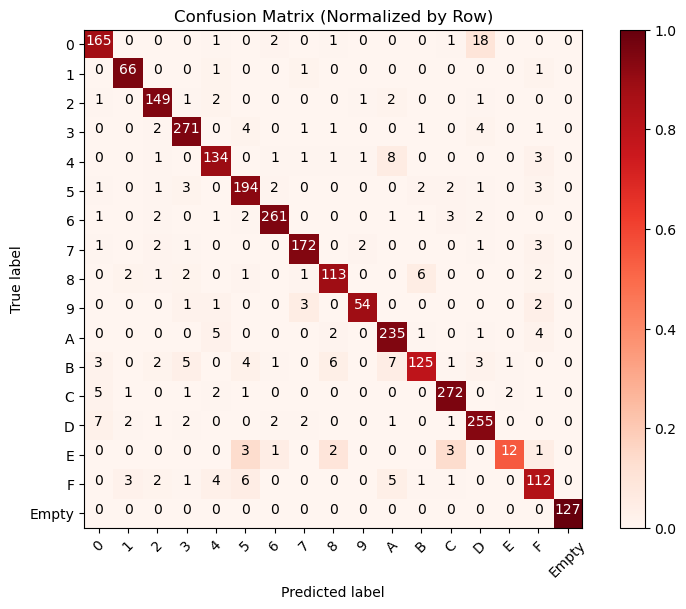

In [266]:
import numpy as np

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'Empty']

cm = confusion_matrix(y_test, best_model.predict(X_test))
# Normalize the confusion matrix by dividing each value by the sum of its respective row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix using matplotlib with normalized values for colors
plt.figure(figsize=(8, 6))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Normalized by Row)')
plt.colorbar()

tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Annotating the matrix with numbers (showing the actual counts, not normalized values)
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > cm_normalized.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Looking at images that the classifier gets wrong:

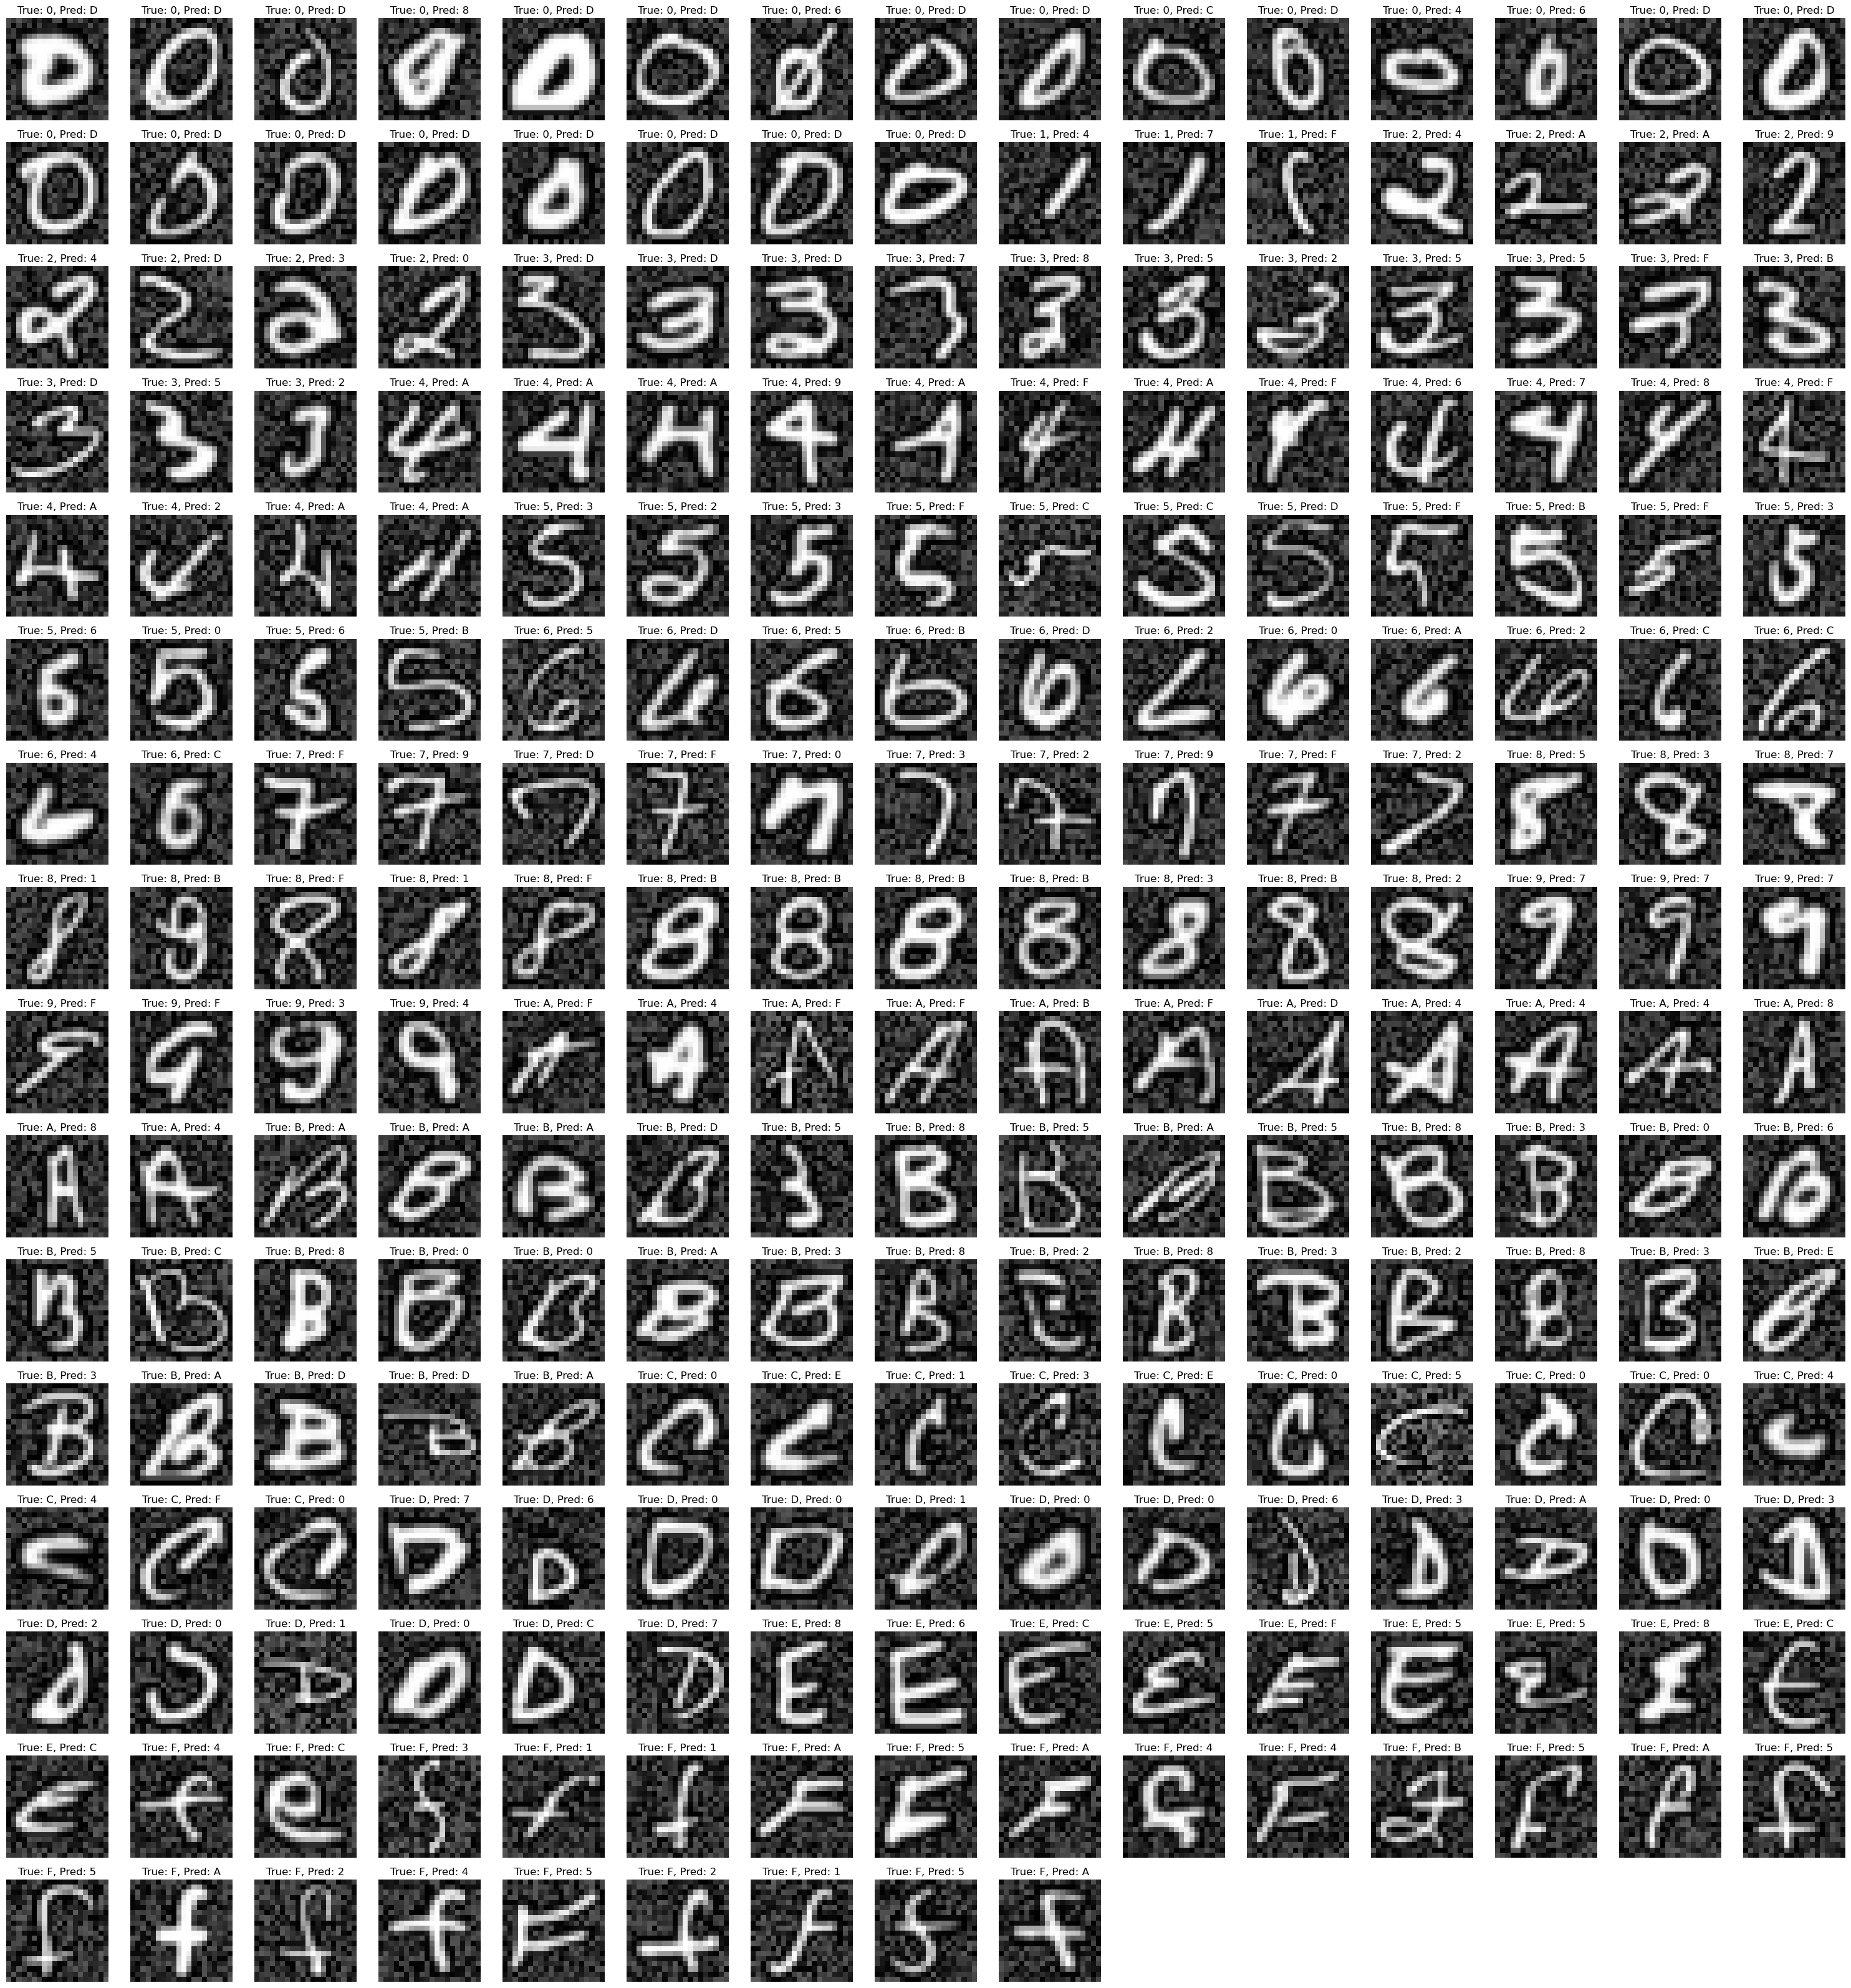

In [267]:
# Get predictions from the best model
y_pred = best_model.predict(X_test)

# Find indices where the predictions and true labels don't match
misclassified_indices = np.where(y_test != y_pred)[0]

# Sort the misclassified indices by the true class
misclassified_indices_sorted = misclassified_indices[np.argsort(y_test[misclassified_indices])]

# Define the number of images per row
images_per_row = 15

# Calculate the total number of misclassified images
total_misclassified = len(misclassified_indices_sorted)

# Calculate the number of rows needed
num_rows = (total_misclassified + images_per_row - 1) // images_per_row

# Plot misclassified images, sorted by true class
plt.figure(figsize=(images_per_row * 2, num_rows * 2))

for i, index in enumerate(misclassified_indices_sorted):
    plt.subplot(num_rows, images_per_row, i + 1)
    plt.imshow(X_test[index].reshape(20, 20), cmap='gray')  # Assuming images are 20x20
    plt.title(f"True: {class_names[y_test[index]]}, Pred: {class_names[y_pred[index]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Precision-recall curve for each class:

Best model SVM


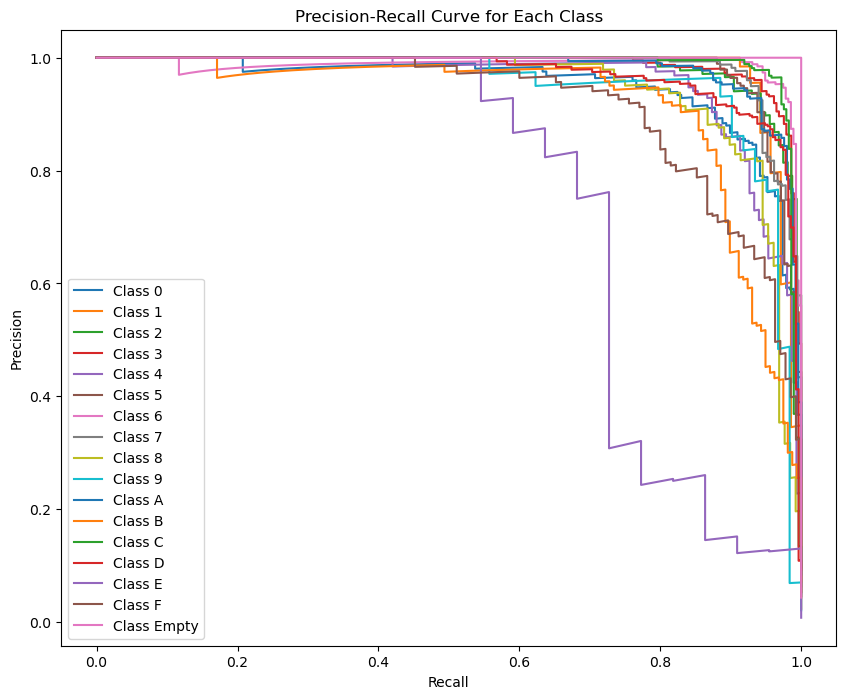

In [268]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

if "SVC" in  (str(best_model)):
    print("Best model SVM")
    best_model = SVC(probability=True,C=grid_search_SVM.best_params_.get("C"),kernel=grid_search_SVM.best_params_.get("kernel"),gamma=grid_search_SVM.best_params_.get("gamma"),degree= grid_search_SVM.best_params_.get("degree"))
    # Needed to add probaility=True if the best model is SVM because it is needed for the plot.
else:
    print("Best model RF")
    



best_model.fit(X_train_val, y_train_val)
param_grid = {
    'C': [0.1],  # Regularization parameter
    'kernel': ['linear'],  # Kernel type to be used in the algorithm
    'gamma': ['scale'],  # Kernel coefficient
    'degree': [2]  # Degree of the polynomial kernel function ('poly')
}
# Binarize the labels for each class (necessary for multi-class precision-recall curve)
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
y_pred_proba = best_model.predict_proba(X_test)

plt.figure(figsize=(10, 8))

# Plot Precision-Recall curve for each class
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {class_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='best')
plt.show()


# Problem 2:  Dimensionality Reduction

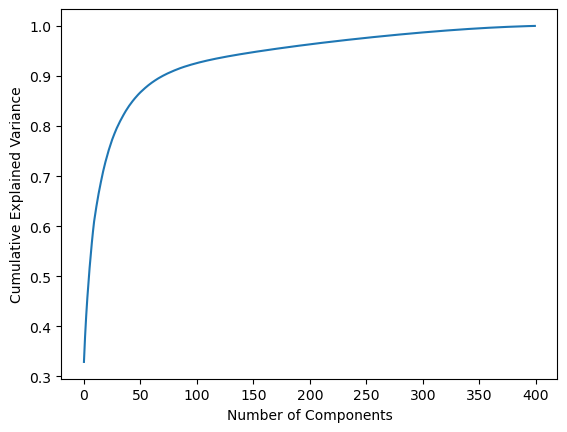

In [269]:
from sklearn.decomposition import PCA
pca = PCA(random_state=seed).fit(X_train_val)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [286]:
from sklearn.decomposition import PCA

# List of n_components values to test
n_components_list = [10, 20, 50, 100, 200]

# Define a structure to store the results
results = []


if "SVC" in  (str(best_model)):
    print("Best model SVM")
    # Define the hyperparameters to tune
    param_grid = {
        'C': [1, 10, 100],  # Regularization parameter
        'kernel': ['rbf', 'poly'],  # Kernel type to be used in the algorithm
        'gamma': ['scale', 'auto'],  # Kernel coefficient
        'degree': [2,3]  # Degree of the polynomial kernel function ('poly')
    }
    # Here we tune less parameters because we don't want it to take too long of time
    model = SVC(random_state=seed)
else:
    print("Best model RF")
    param_grid = {
    'n_estimators': [10,20,40],  # Number of trees in the forest
    'max_depth': [10,15,20],  # Maximum depth of the trees
    'max_features': ['sqrt','log2'], # Number of features to consider for best split
    'criterion': ['entropy','gini'] # How to compute the information gain when splitting
    }
    model = RandomForestClassifier(random_state=seed)



for dimensions in n_components_list:
    start_time = time.time()

    # Perform PCA
    pca = PCA(n_components=dimensions, random_state=seed)
    X_train_val_pca = pca.fit_transform(X_train_val)

    # Calculate total variance explained
    total_variance_explained = pca.explained_variance_ratio_.sum()
    

    # Set up GridSearchCV with SVM
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               scoring='accuracy', 
                               cv=5, n_jobs=-1, verbose=0)
    
    # Fit the grid search to the data
    grid_search.fit(X_train_val_pca, y_train_val)
    
    # Get the best hyperparameters and cross-validation accuracy
    best_hyperparams = grid_search.best_params_
    best_cv_accuracy = grid_search.best_score_

    end_time = time.time()
    execution_time = end_time - start_time
    
    # Store the results in the results list
    results.append({
        'n_components': dimensions,
        'total_variance_explained': total_variance_explained,
        'best_hyperparameters': best_hyperparams,
        'best_cv_accuracy': best_cv_accuracy,
        'execution_time': execution_time
    })

Best model SVM


## Results when PCA is set to n_components = 10:

In [287]:
for key, val in results[0].items():
        print(f"{key}: {val}")    

n_components: 10
total_variance_explained: 0.6096659625927977
best_hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
best_cv_accuracy: 0.9172932330827068
execution_time: 15.35850191116333


## Results when PCA is set to n_components = 20:

In [288]:
for key, val in results[1].items():
        print(f"{key}: {val}")   

n_components: 20
total_variance_explained: 0.7282308097030559
best_hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
best_cv_accuracy: 0.9576293675364882
execution_time: 13.467512845993042


## Results when PCA is set to n_components = 50:

In [289]:
for key, val in results[2].items():
        print(f"{key}: {val}")  

n_components: 50
total_variance_explained: 0.8653034195744087
best_hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
best_cv_accuracy: 0.9707209199469261
execution_time: 19.13480257987976


## Results when PCA is set to n_components = 100:

In [290]:
for key, val in results[3].items():
        print(f"{key}: {val}")  

n_components: 100
total_variance_explained: 0.925265560636292
best_hyperparameters: {'C': 100, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
best_cv_accuracy: 0.9737284387439187
execution_time: 41.122032165527344


## Results when PCA is set to n_components = 200:

In [291]:
for key, val in results[4].items():
        print(f"{key}: {val}")  

n_components: 200
total_variance_explained: 0.9630181749300475
best_hyperparameters: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
best_cv_accuracy: 0.9721362229102167
execution_time: 96.31816577911377


### Checking which n_components was the best:

The best result was with n_components set to 100 with cross-validation accuracy of 0.9737284387439187.

And this was with these hyperparameters: {'C': 100, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}.

This had a execution time of 160 seconds compared to ... # TODO

Testing this on testdata:

In [276]:
pca = PCA(n_components=100, random_state=seed)
X_train_val_pca = pca.fit_transform(X_train_val)
X_test_pca = pca.transform(X_test)

svm = SVC(random_state = seed,C=100, degree=3, gamma='scale', kernel='poly') #SVM since this was the best in problem 1

svm.fit(X_train_val_pca,y_train_val)

print(classification_report(y_test, svm.predict(X_test_pca)))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       188
           1       0.94      0.96      0.95        69
           2       0.90      0.94      0.92       157
           3       0.95      0.96      0.96       285
           4       0.92      0.87      0.90       150
           5       0.95      0.93      0.94       209
           6       0.97      0.96      0.97       274
           7       0.96      0.95      0.95       182
           8       0.91      0.90      0.91       128
           9       0.93      0.89      0.91        61
          10       0.93      0.96      0.94       248
          11       0.85      0.84      0.84       158
          12       0.96      0.96      0.96       285
          13       0.89      0.94      0.91       273
          14       0.89      0.73      0.80        22
          15       0.87      0.90      0.88       135
          16       1.00      1.00      1.00       127

    accuracy              

## Looking at the confusion matrix for this:

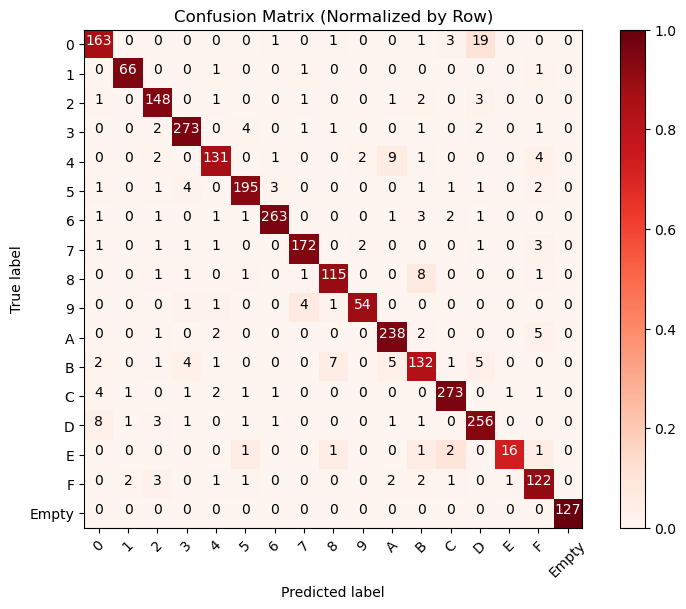

In [277]:
import numpy as np

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'Empty']

cm = confusion_matrix(y_test, svm.predict(X_test_pca))
# Normalize the confusion matrix by dividing each value by the sum of its respective row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix using matplotlib with normalized values for colors
plt.figure(figsize=(8, 6))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Normalized by Row)')
plt.colorbar()

tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Annotating the matrix with numbers (showing the actual counts, not normalized values)
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > cm_normalized.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Problem 3: Detecting Out-of-Distribution Images


Different approaches to find the out of dist images:


Approach 1: Based on the smallest difference between the top two probabilities.

Approach 2: Based on entropy, which measures the overall uncertainty of the probability distribution.

Approach 3: Combining the two approaches above in a clever way.


We counted which of these approaches had the most out of distribution images in them and went with that one. When showing the results for each approach we then get a number divided by 85 (X/85).

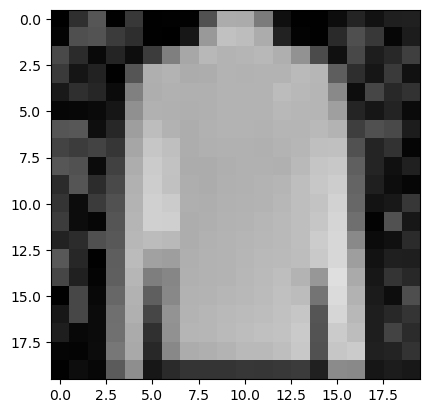

In [278]:
# Loading the dataset
dataset = np.load("corrupt_dataset.npz")
X = dataset["X"]

# Normalise the data
X = X / 255.0


x = 109
# Here we plot a image and we can see that this is an unlabeled image
plt.imshow(X[x].reshape(20, 20), vmin=0, vmax=1, cmap="gray")
plt.show()

In [309]:
# Loading the dataset
dataset = np.load("dataset.npz")
oldX, oldy = dataset["X"], dataset["y"]

oldX = oldX / 255.0

# Oversample our data with Smote
smote = SMOTE(random_state=seed)
oldX, oldy = smote.fit_resample(oldX, oldy) 


# We want to use SVM with PCA set to 100 and with the following parameters, because this gave us the best results
svm = SVC(probability=True, random_state=seed, C=100, degree=3, gamma='scale', kernel='poly') # Our final classifier

# Performing PCA
pca = PCA(n_components=100, random_state=seed)
oldXpca = pca.fit_transform(oldX)
X_corrupt_pca = pca.transform(X)

# Fit out classifier
svm.fit(oldXpca, oldy)

predicts = svm.predict_proba(X_corrupt_pca)

### Showing all of the pictures:

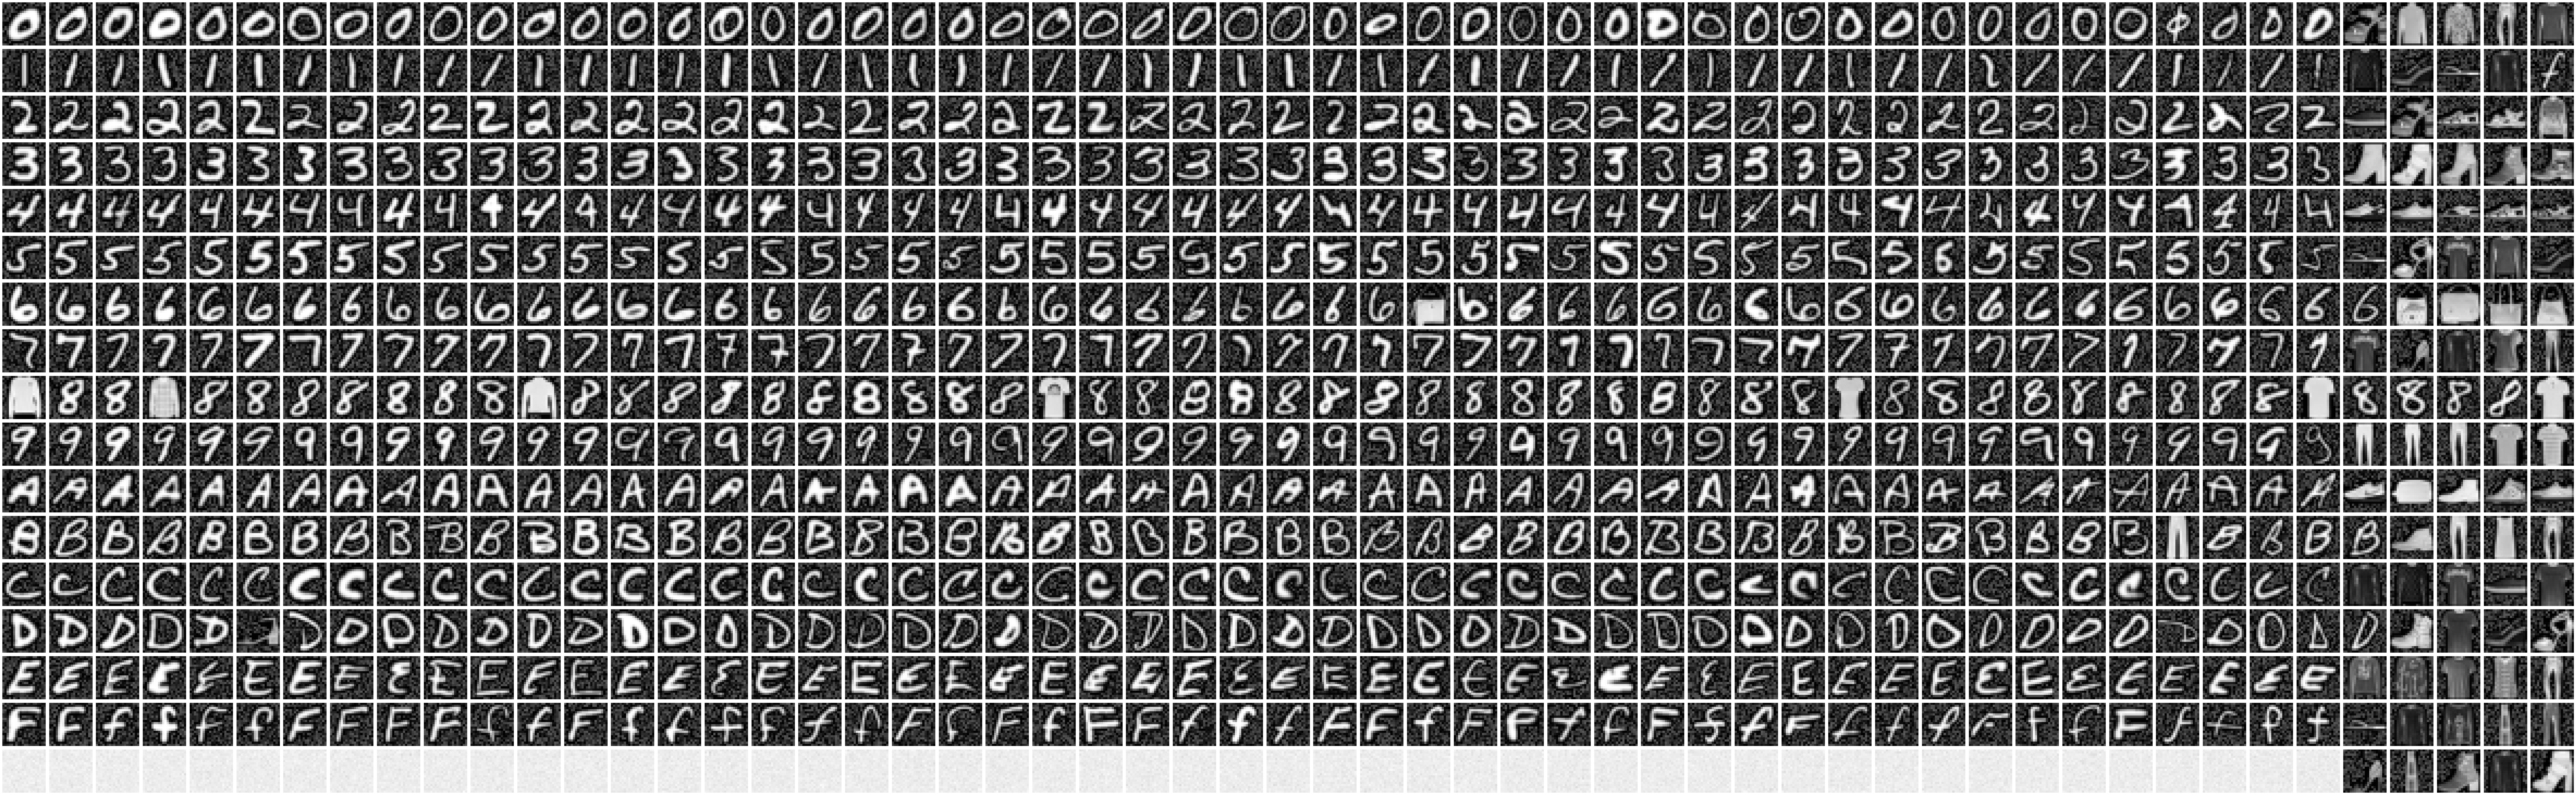

In [321]:
num_classes = predicts.shape[1]  # Get the number of classes (0-Empty)
images_per_class = 55 # Since we have 935 in total we can show 55 per row because we have 17 classes. (935/17=55)
image_size = (20, 20)  # Size of images

fig, axes = plt.subplots(num_classes, images_per_class, figsize=(images_per_class * 2, num_classes * 2))

# Step 3: Loop over each class and find the most confident images
for class_idx in range(num_classes):
    # Sort the images by probability for the current class
    most_confident_indices = np.argsort(-predicts[:, class_idx])[:images_per_class]
    
    for img_idx, ax in enumerate(axes[class_idx]):
        image = X[most_confident_indices[img_idx]].reshape(image_size)
        ax.imshow(image, vmin=0, vmax=1, cmap="gray")
        ax.axis('off')  # Turn off axis labels

    # Add a class label on the left
    axes[class_idx, 0].set_ylabel(f'Class {class_idx}', fontsize=12, labelpad=10)

# Show the figure
plt.tight_layout()
plt.show()


### Above we can see all of the images in the dataset, we see that a lot of them look like clothes


# Finding the out of distribution images:

In [311]:
predicts_proba = svm.predict_proba(X_corrupt_pca)

### Approach 1. Results for calculating the difference between the highest and second-highest probabilities:
75/85!

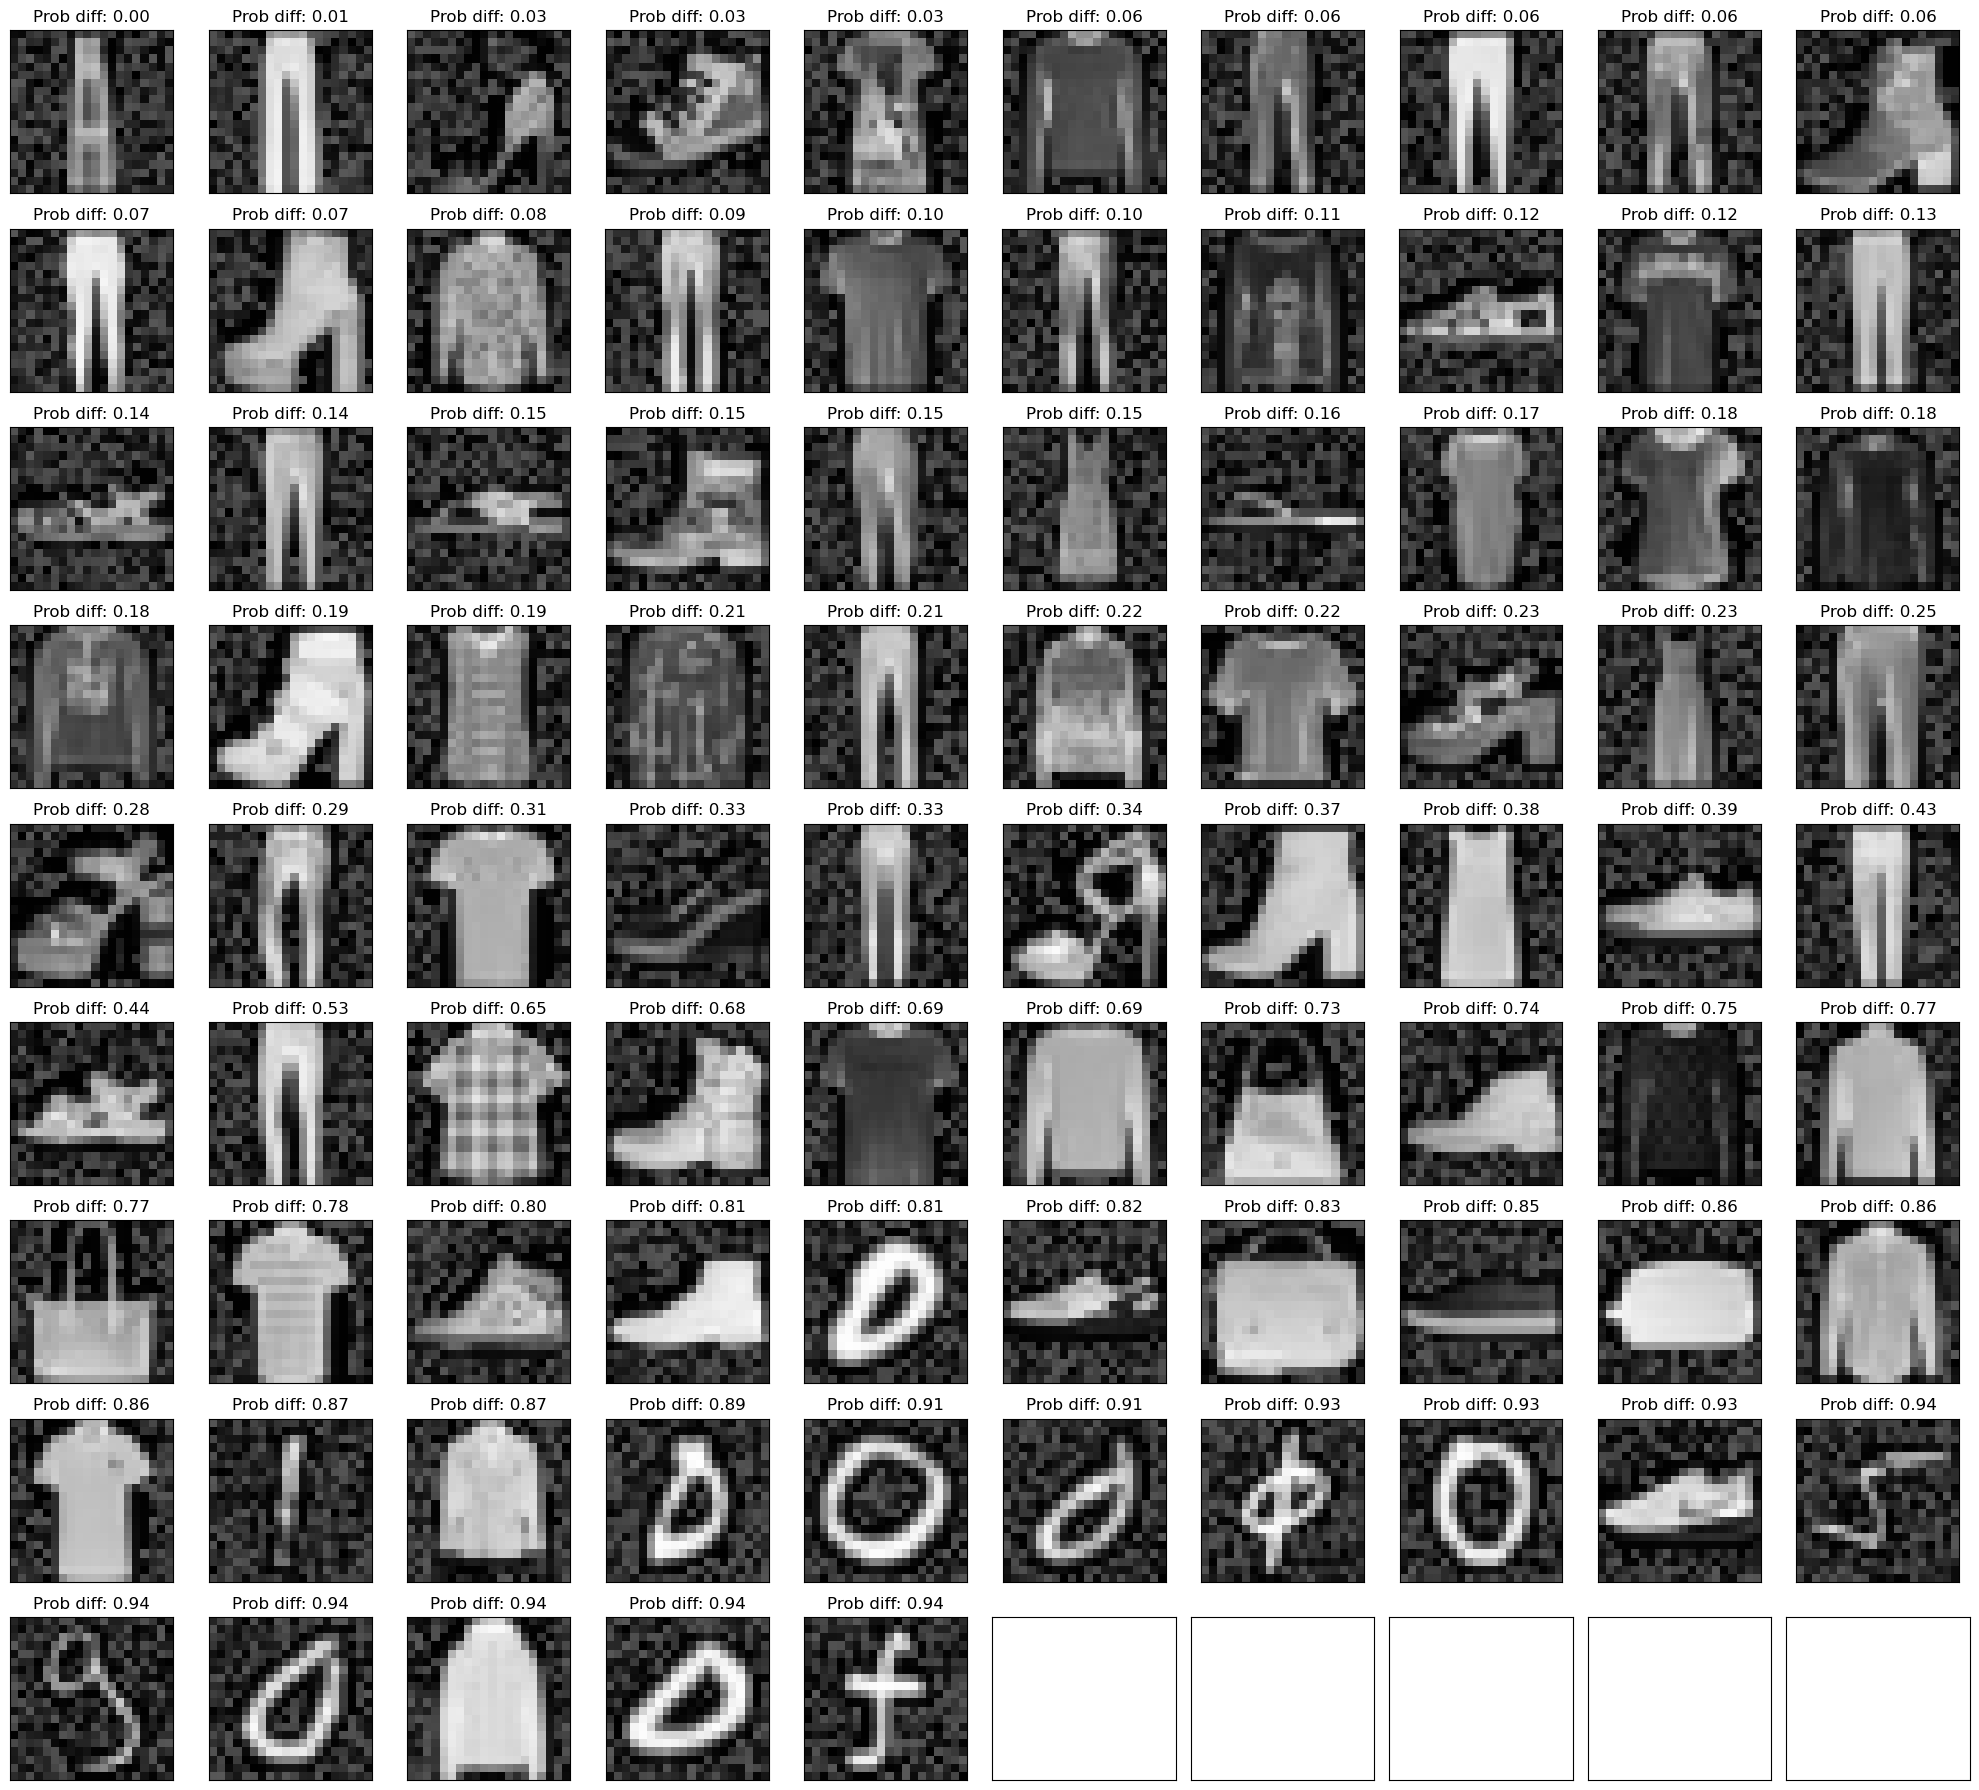

In [312]:
sorted_probs = np.sort(predicts_proba, axis=1)  # Sort the probabilities for each image
prob_diffs = sorted_probs[:, -1] - sorted_probs[:, -2]  # Difference between the two largest probabilities

# Sort by uncertainty (smallest difference = most uncertain)
most_uncertain_indices = np.argsort(prob_diffs)  # Sorted from smallest to largest difference

# Plot the most uncertain images, from highest uncertainty to lowest
num_uncertain = 85  # Since there is 85 unlabeled images
images_per_row = 10  # Number of images per row in the plot
num_rows = (num_uncertain + images_per_row - 1) // images_per_row  # Calculate number of rows

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

for i, ax in enumerate(axes.flat):
    if i < num_uncertain:
        image_idx = most_uncertain_indices[i]  # Start with the most uncertain
        image = X[image_idx].reshape(20, 20)  # Assuming the images are 20x20
        ax.imshow(image, vmin=0, vmax=1, cmap="gray")
        ax.set_title(f"Prob diff: {prob_diffs[image_idx]:.2f}")
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks

plt.tight_layout()
plt.show()


### Approach 2. Result for calculating the entropy for each image:
72/85

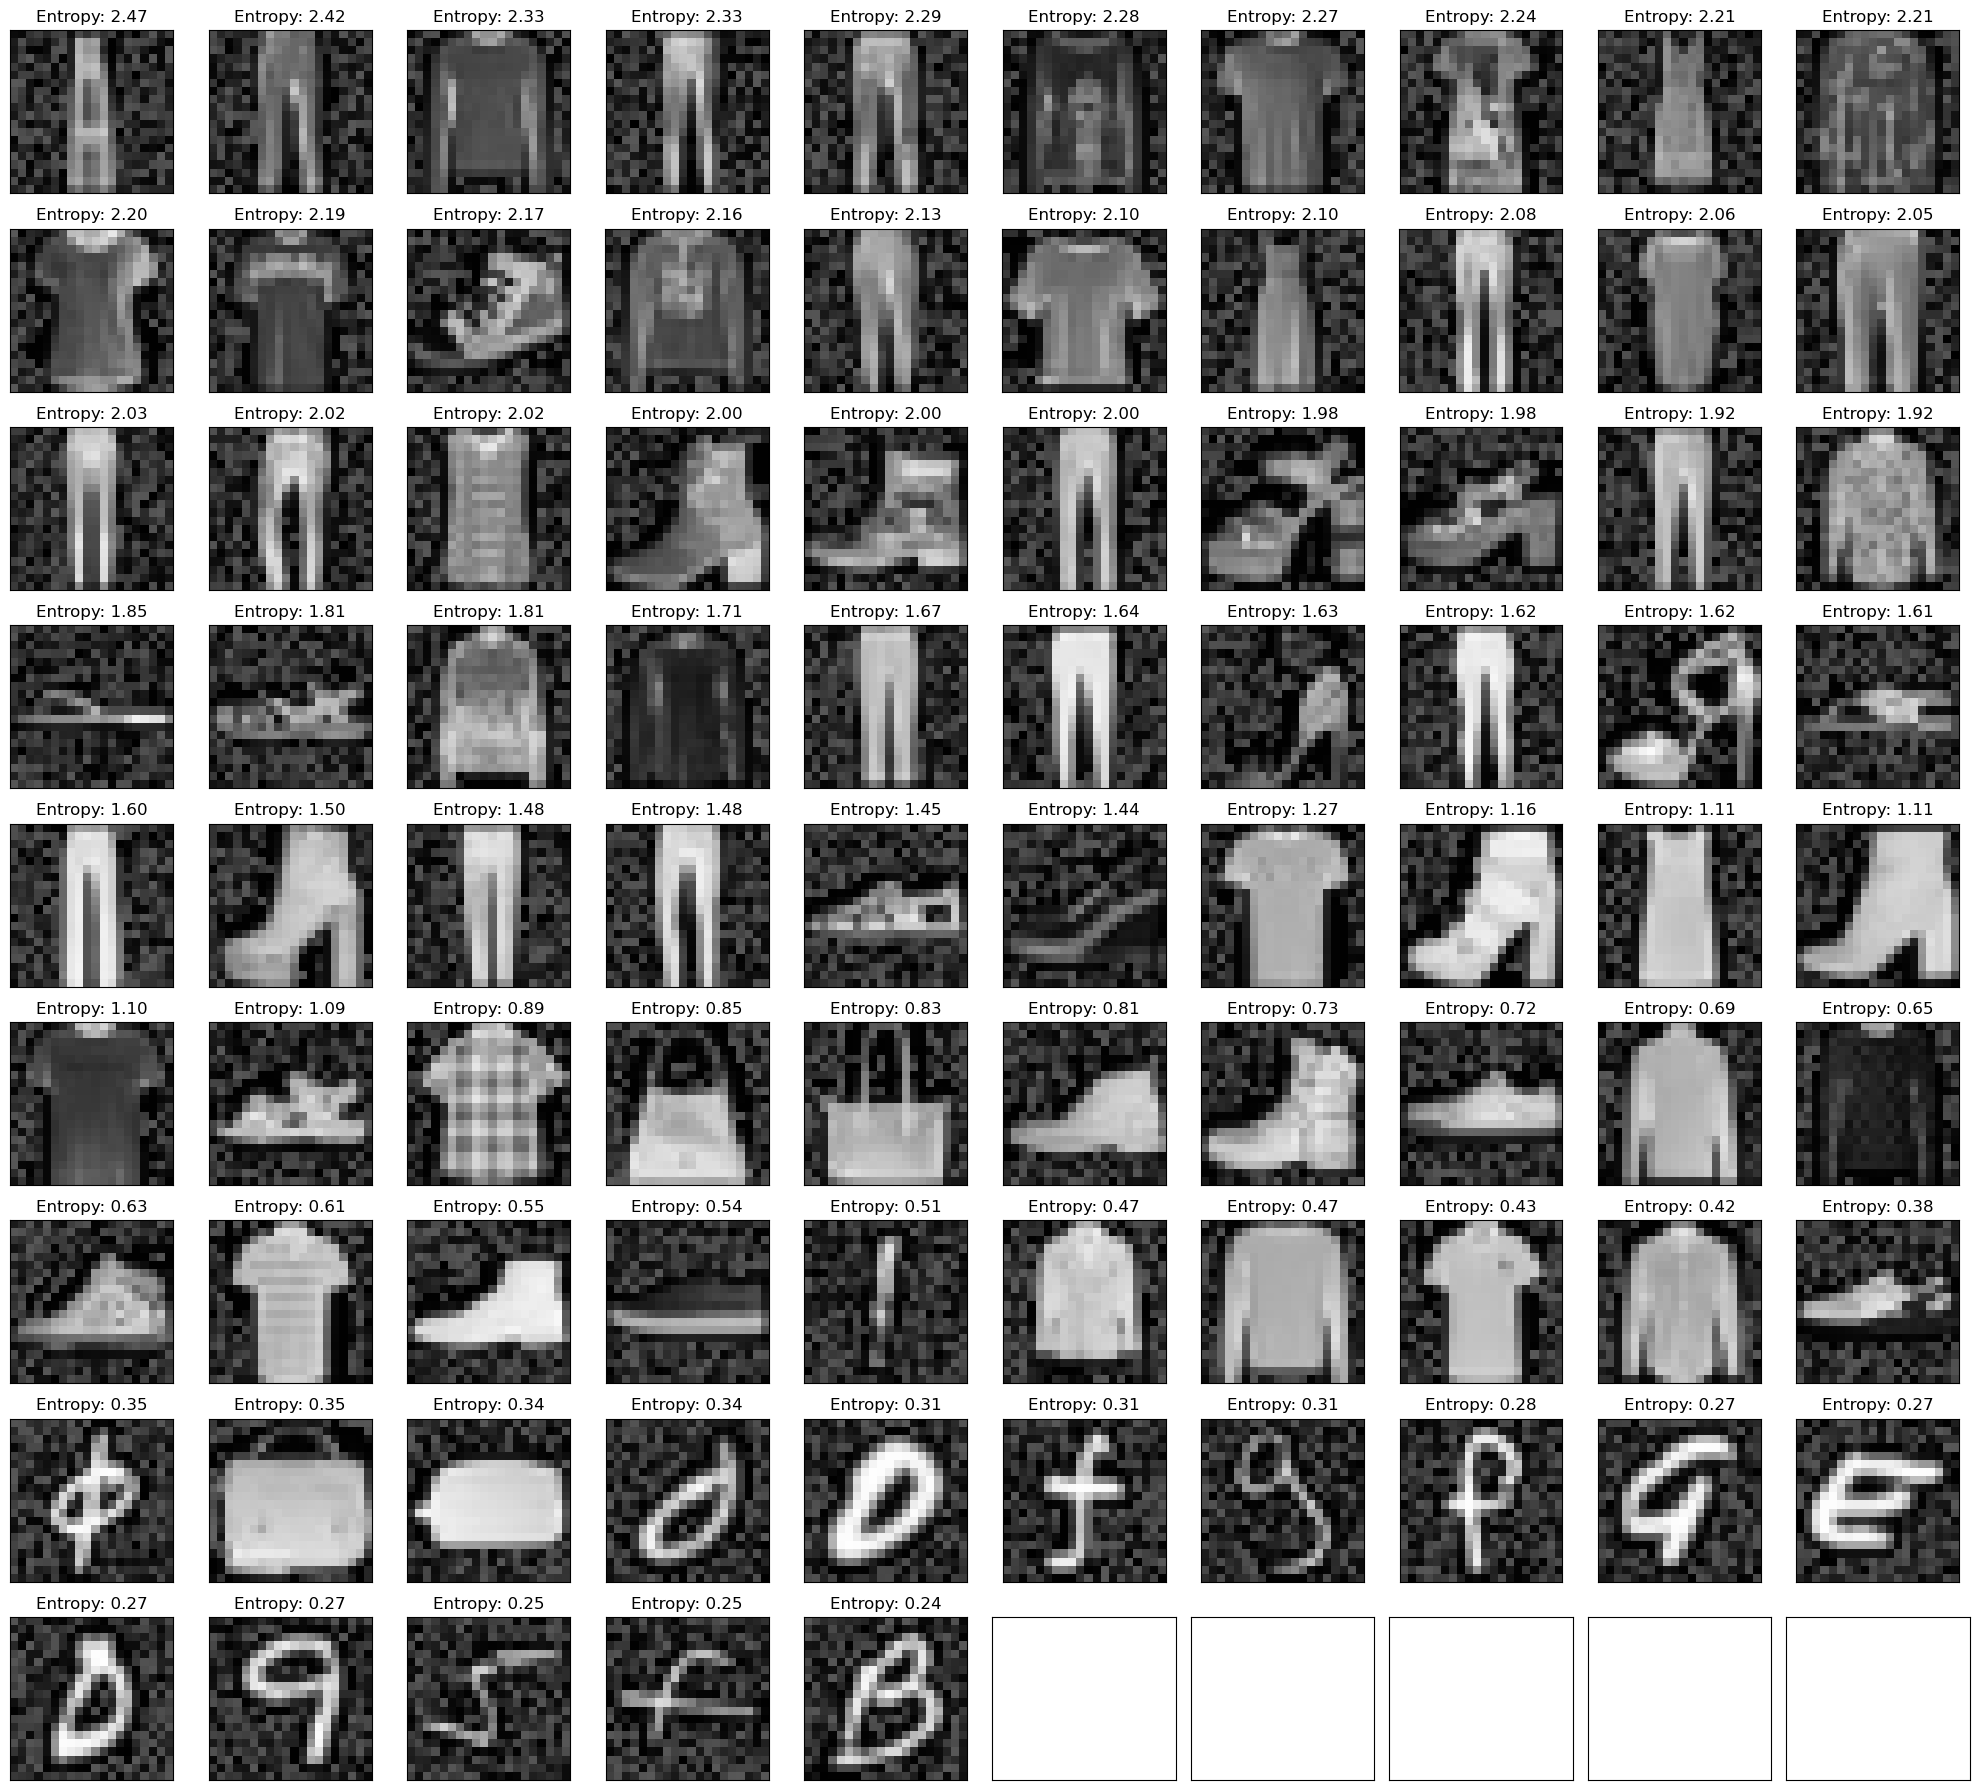

In [314]:
from scipy.stats import entropy

# Step 1: Calculate entropy for each image
entropies = np.apply_along_axis(entropy, 1, predicts_proba)  # Apply entropy along axis 1

# Step 2: Sort by entropy (highest entropy = most uncertain)
most_uncertain_indices = np.argsort(entropies)[::-1]  # Sort in descending order of entropy

# Step 3: Plot the most uncertain images based on entropy
num_uncertain = 85 # Number of most uncertain images to display
images_per_row = 10  # Number of images per row in the plot
num_rows = (num_uncertain + images_per_row - 1) // images_per_row  # Calculate number of rows

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

for i, ax in enumerate(axes.flat):
    if i < num_uncertain:
        image_idx = most_uncertain_indices[i]
        image = X[image_idx].reshape(20, 20)  # Assuming the images are 20x20
        ax.imshow(image, vmin=0, vmax=1, cmap="gray")
        ax.set_title(f"Entropy: {entropies[image_idx]:.2f}")
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks

plt.tight_layout()
plt.show()


### Plotting to see if we can find any relation to entropy and top difference:

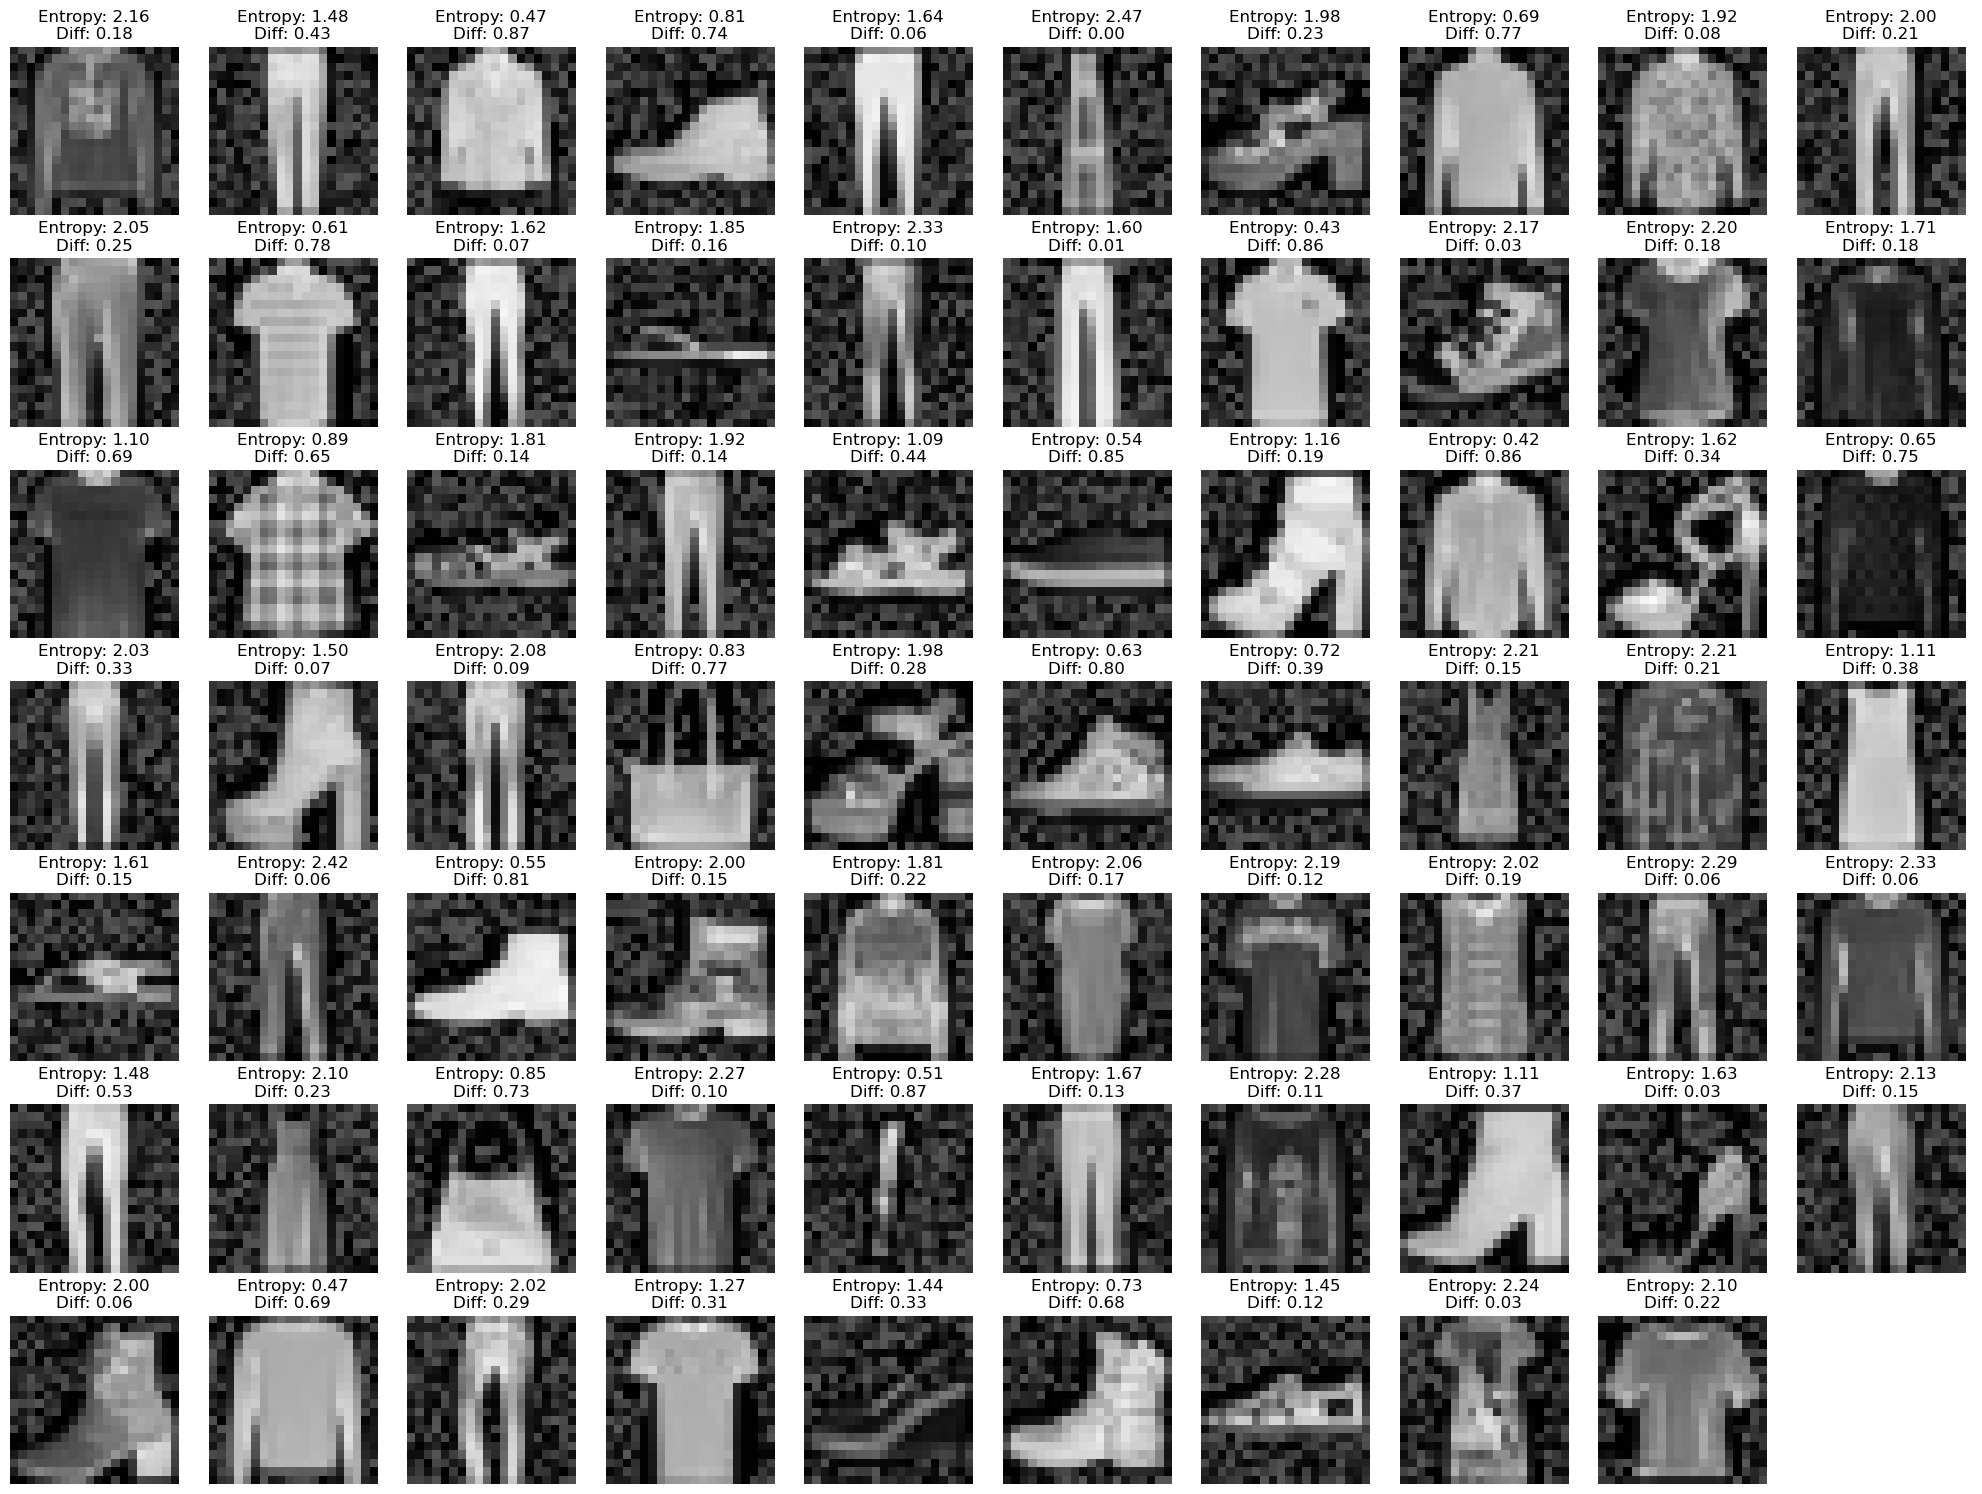

In [297]:
from scipy.stats import entropy

# Step 1: Calculate entropy for each image
entropies = np.apply_along_axis(entropy, 1, predicts_proba)

# Step 2: Combine probability differences and entropy
threshold_diff = 0.1  # You can tune this
threshold_entropy = 0.4  # You can tune this

# Flag images with small probability difference or high entropy
flagged_indices = np.where((prob_diffs < threshold_diff) | (entropies > threshold_entropy))[0]

# Step 3: Plot flagged images
num_flagged = len(flagged_indices)
fig, axes = plt.subplots((num_flagged + 9) // 10, 10, figsize=(20, 2 * (num_flagged + 9) // 10))

for i, ax in enumerate(axes.flat):
    if i < num_flagged:
        image_idx = flagged_indices[i]
        image = X[image_idx].reshape(20, 20)
        ax.imshow(image, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Entropy: {entropies[image_idx]:.2f}\nDiff: {prob_diffs[image_idx]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()


### Approach 3. Combining entropy and top difference in a clever way:
53/85

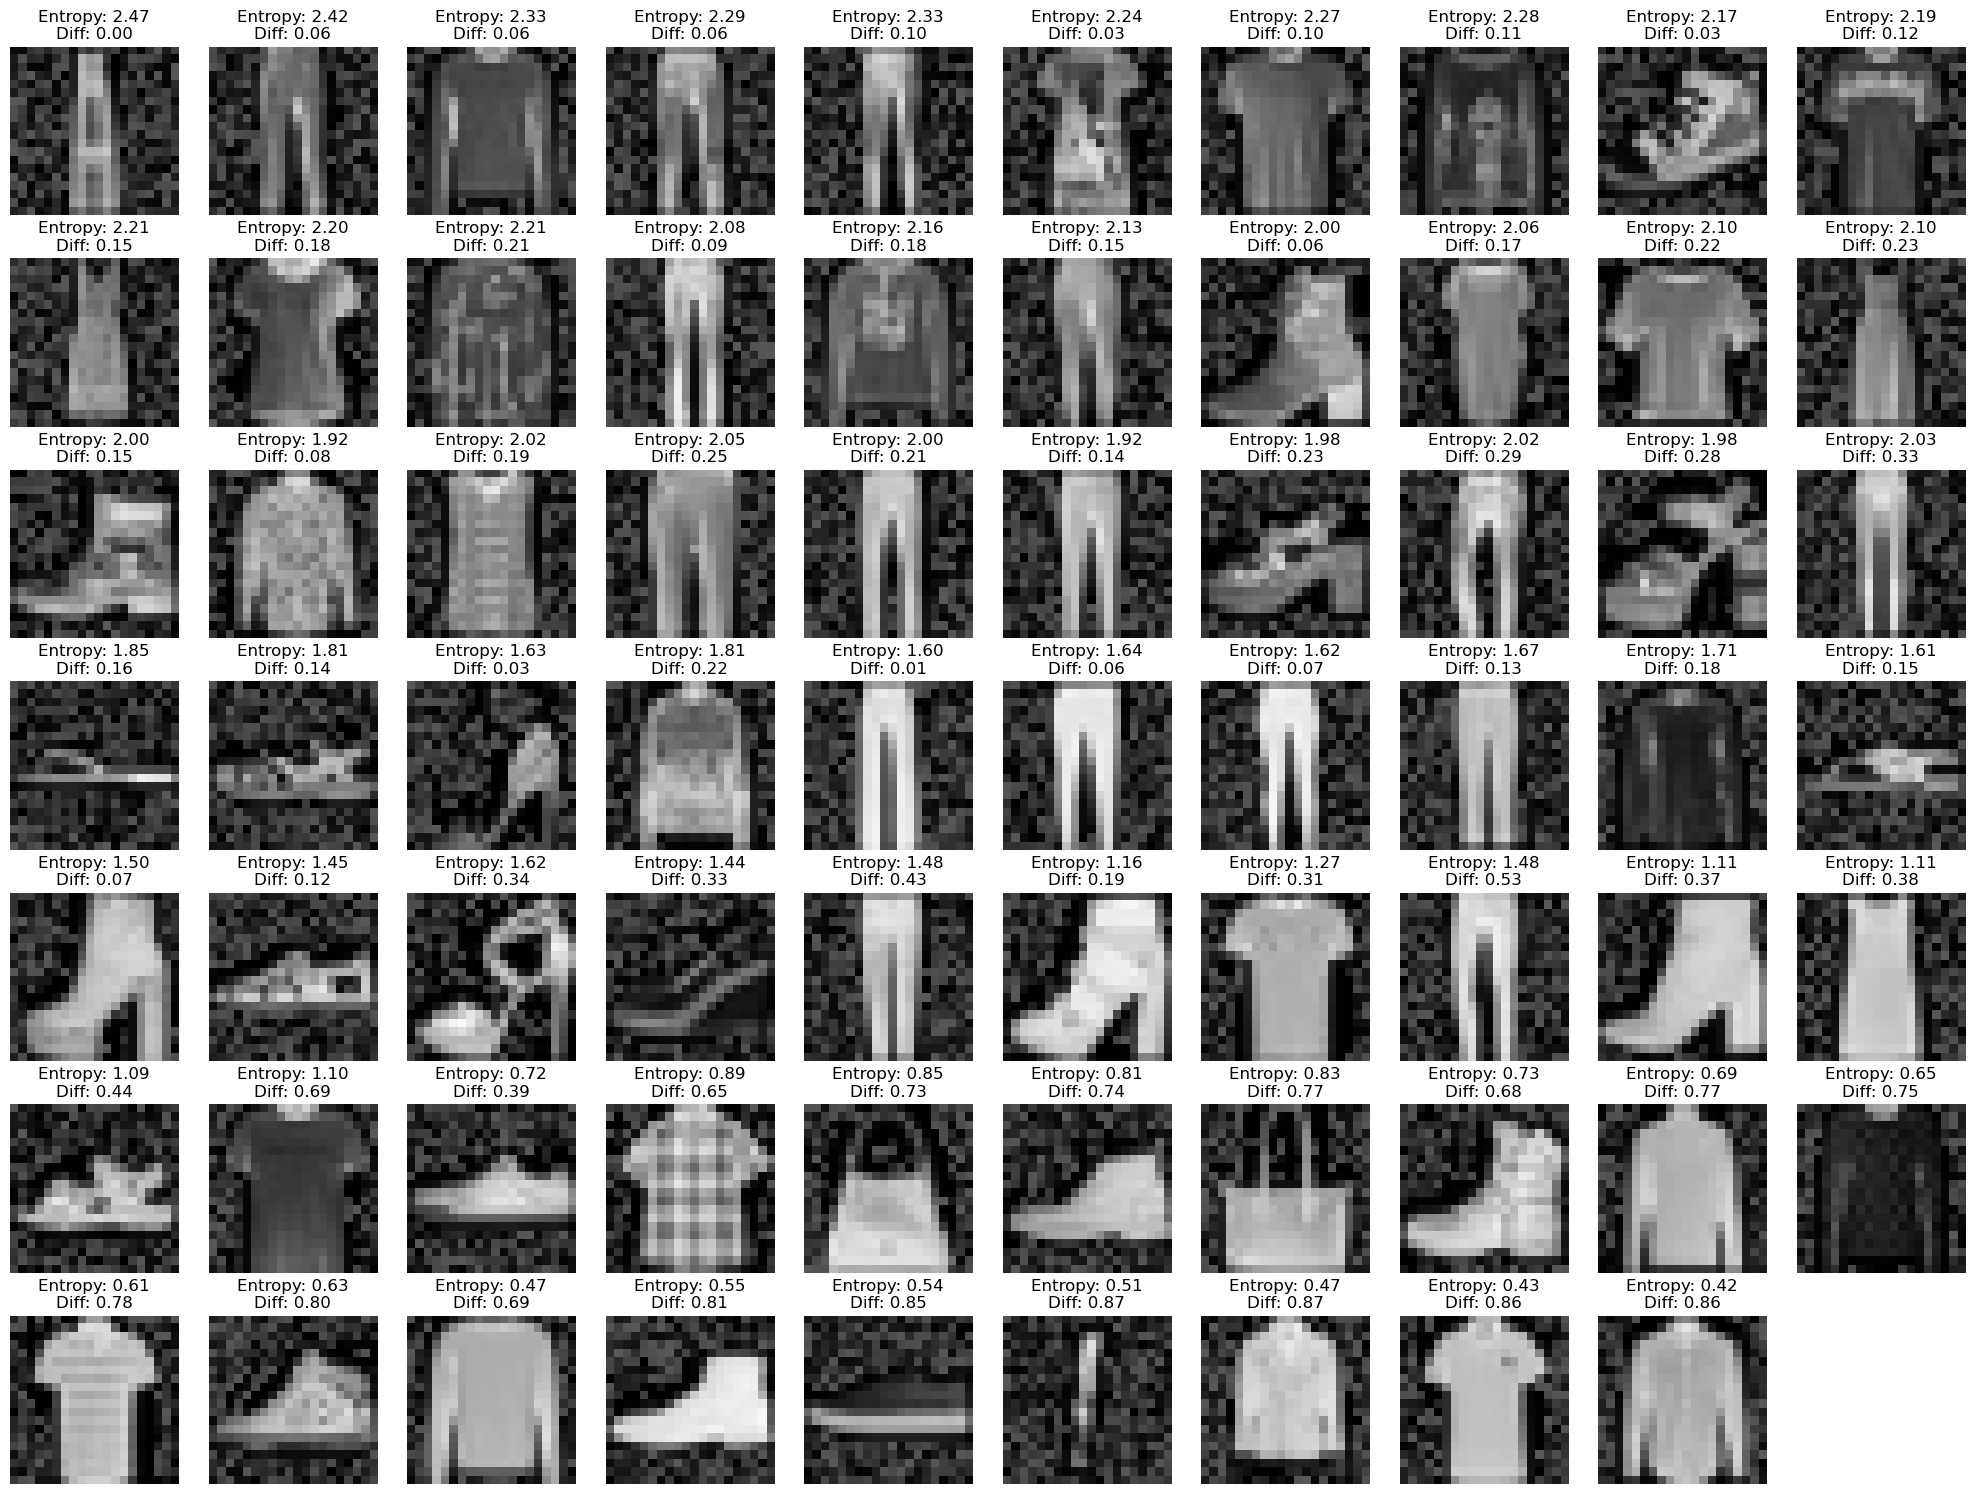

In [315]:
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the necessary data such as predicts_proba, prob_diffs, and X (the image data)

# Step 1: Calculate entropy for each image
entropies = np.apply_along_axis(entropy, 1, predicts_proba)

# Step 2: Combine probability differences and entropy
threshold_diff = 0.1 # You can tune this
threshold_entropy = 0.4  # You can tune this

# Flag images with small probability difference or high entropy
flagged_indices = np.where((prob_diffs < threshold_diff) | (entropies > threshold_entropy))[0]

# Step 3: Sort flagged images by the difference between entropy and probability difference
entropy_diff = entropies[flagged_indices] - prob_diffs[flagged_indices]
sorted_indices = np.argsort(entropy_diff)[::-1]  # Sort in descending order

# Step 4: Limit to the first 85 flagged images
num_to_display = min(85, len(sorted_indices))  # Display up to 85 images

# Step 5: Plot the first 85 flagged and sorted images
fig, axes = plt.subplots((num_to_display + 9) // 10, 10, figsize=(20, 2 * (num_to_display + 9) // 10))

for i, ax in enumerate(axes.flat):
    if i < num_to_display:
        image_idx = flagged_indices[sorted_indices[i]]
        image = X[image_idx].reshape(20, 20)
        ax.imshow(image, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Entropy: {entropies[image_idx]:.2f}\nDiff: {prob_diffs[image_idx]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()


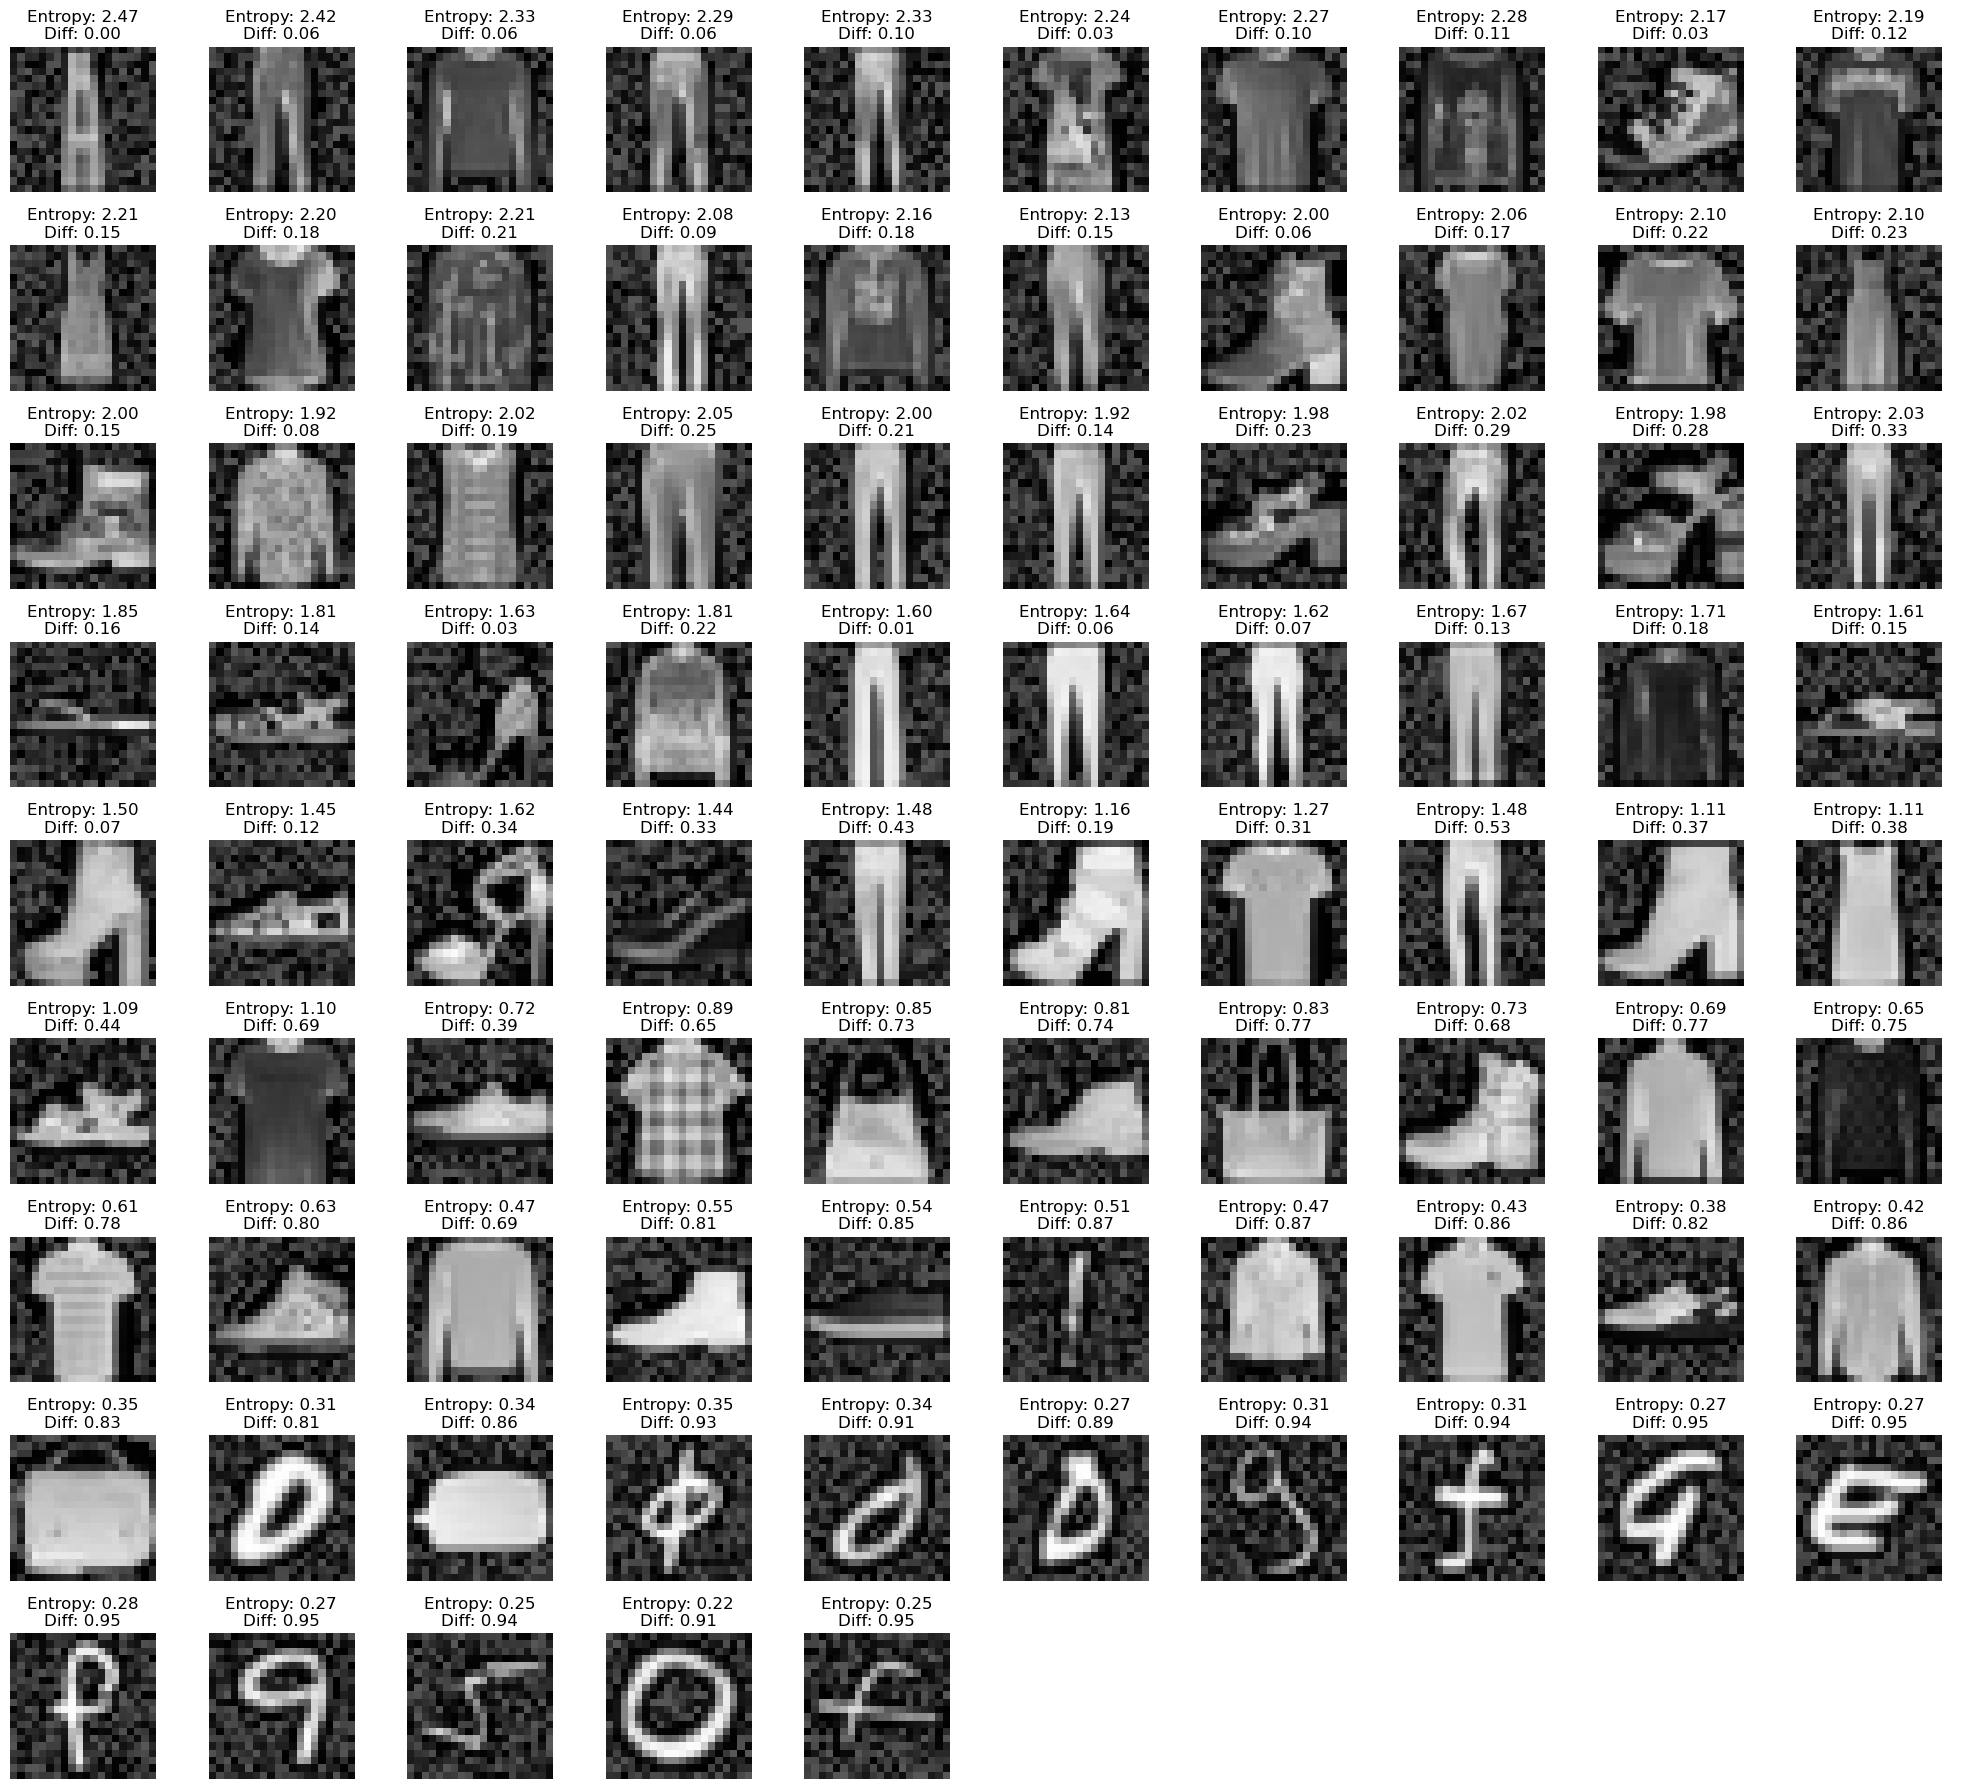

In [316]:
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the necessary data such as predicts_proba, prob_diffs, and X (the image data)

# Step 1: Calculate entropy for each image
entropies = np.apply_along_axis(entropy, 1, predicts_proba)

# Step 2: Combine probability differences and entropy
# Calculate the difference between entropy and probability difference
entropy_diff = entropies - prob_diffs

# Step 3: Sort images by the difference between entropy and probability difference
sorted_indices = np.argsort(entropy_diff)[::-1]  # Sort in descending order

# Step 4: Limit to the first 85 images
num_to_display = min(85, len(sorted_indices))  # Ensure we only display up to 85 images

# Step 5: Plot the first 85 sorted images
fig, axes = plt.subplots((num_to_display + 9) // 10, 10, figsize=(20, 2 * (num_to_display + 9) // 10))

for i, ax in enumerate(axes.flat):
    if i < num_to_display:
        image_idx = sorted_indices[i]
        image = X[image_idx].reshape(20, 20)
        ax.imshow(image, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Entropy: {entropies[image_idx]:.2f}\nDiff: {prob_diffs[image_idx]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Experimenting

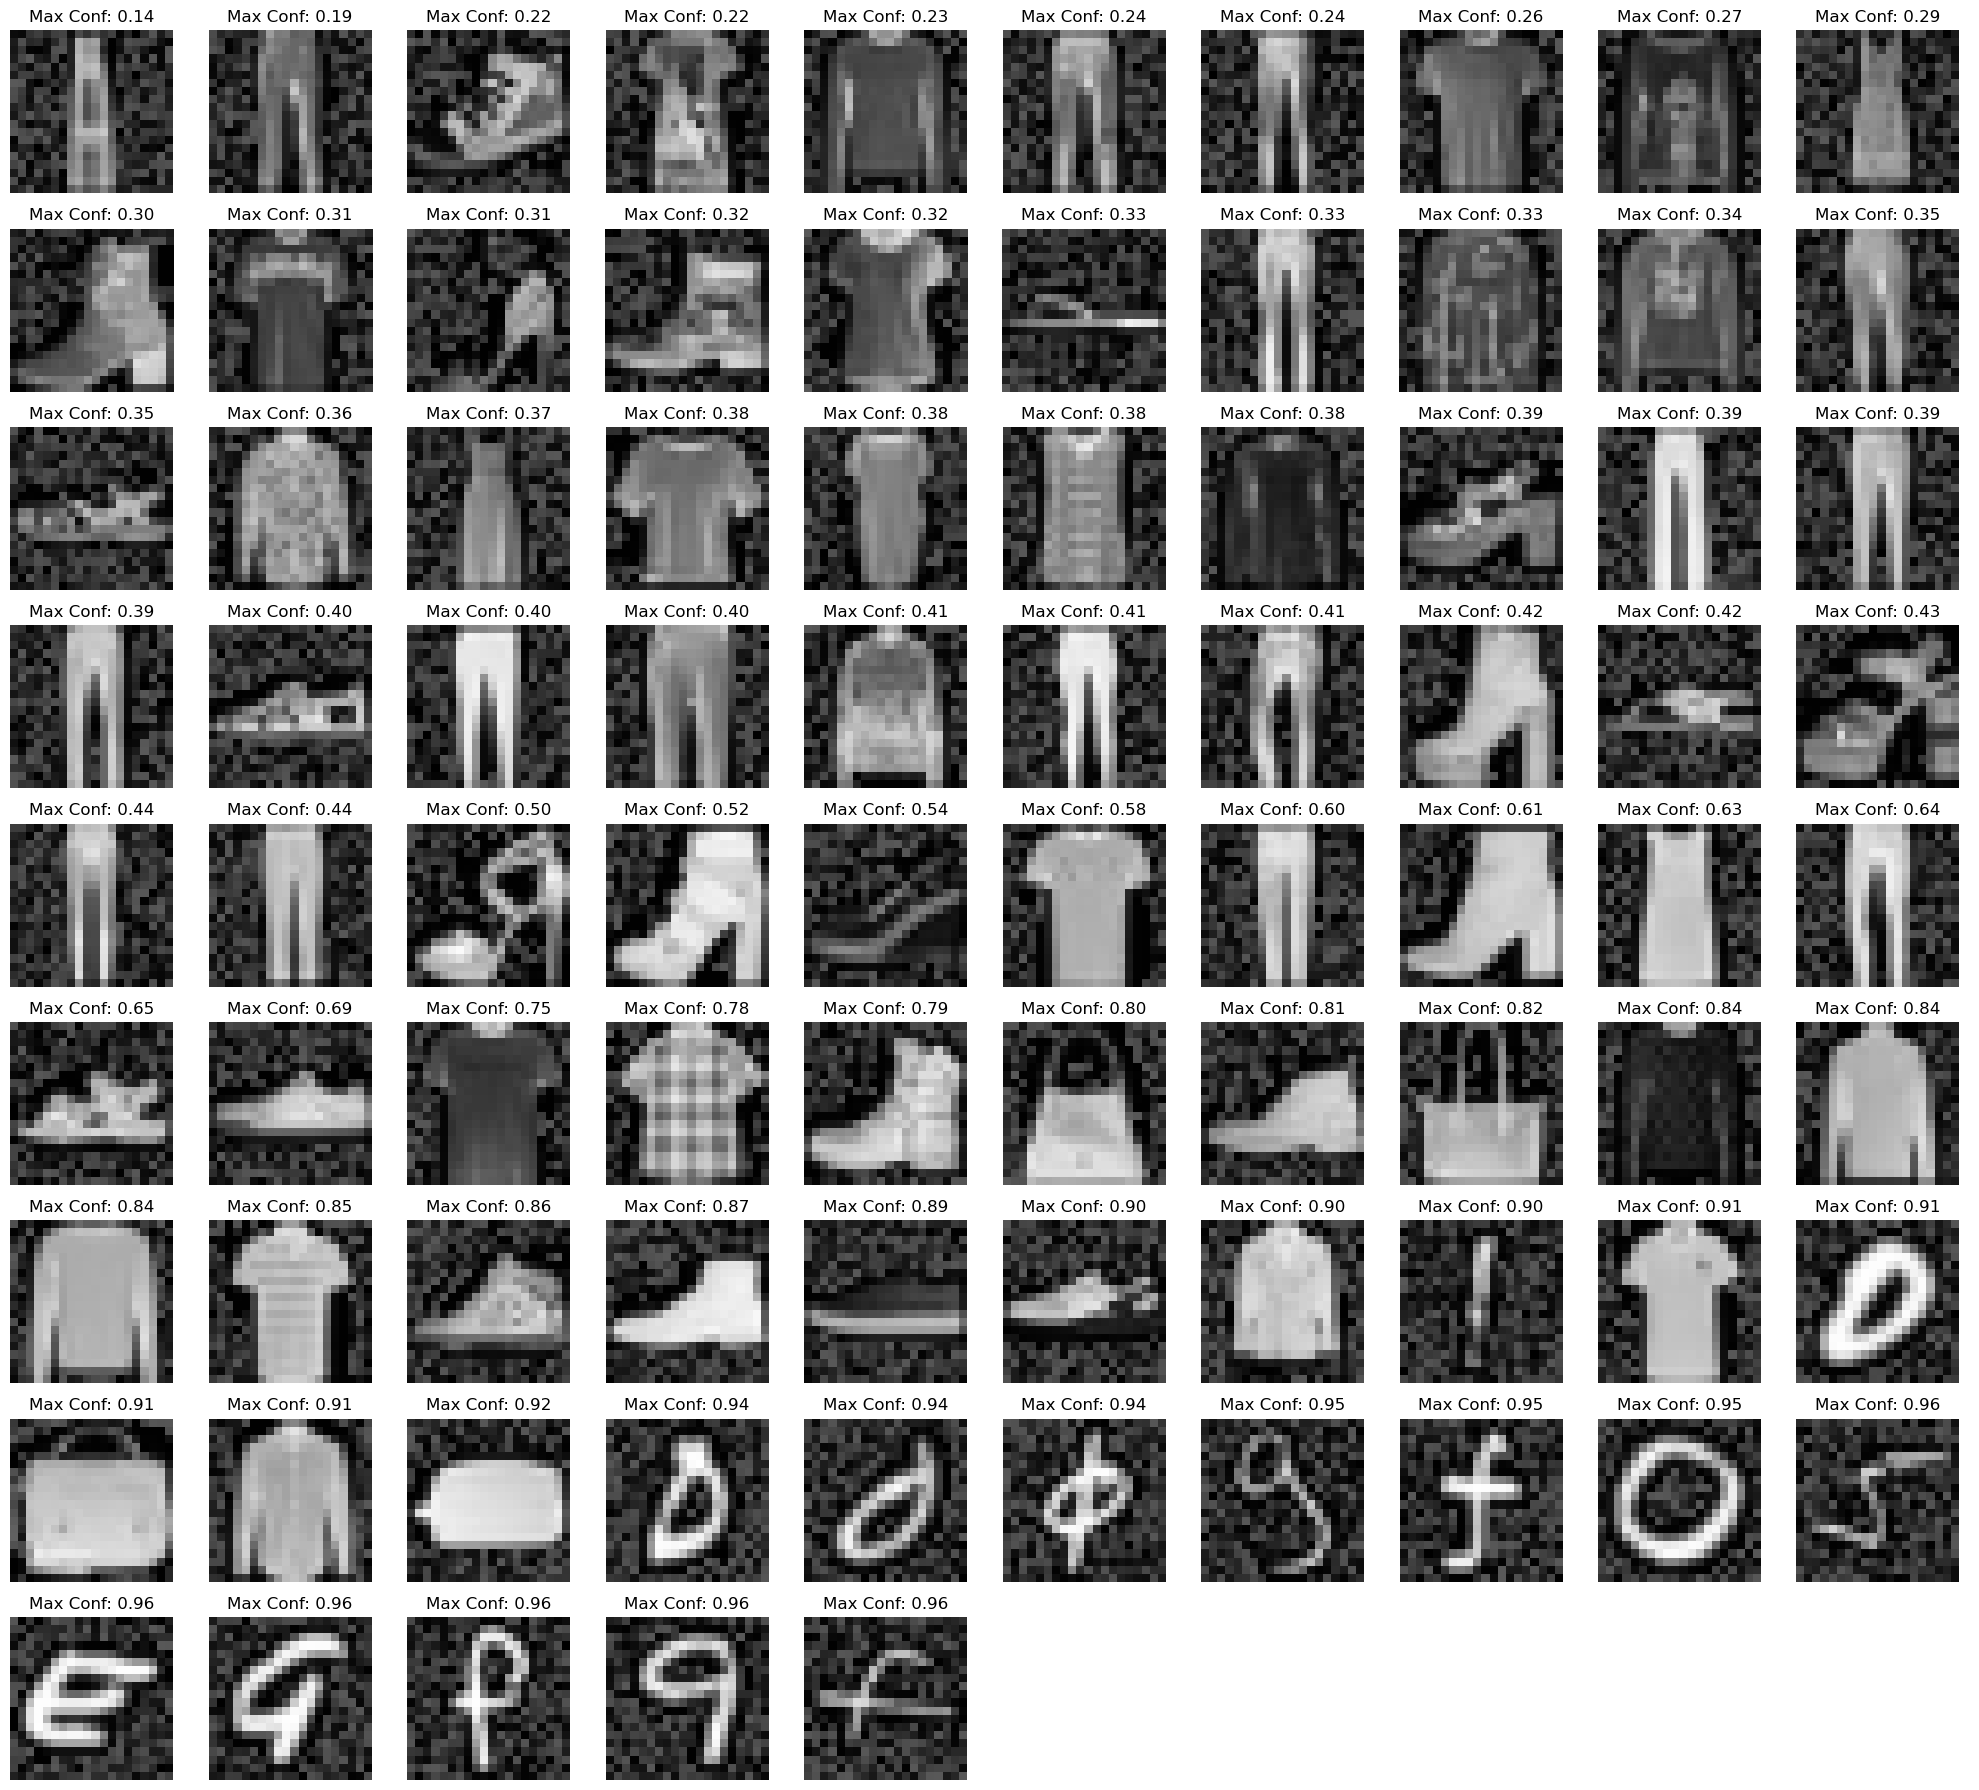

In [328]:
# Step 1: Calculate Maximum Probability (confidence) for each image
max_confidences = np.max(predicts_proba, axis=1)

# Step 2: Sort by Maximum Probability (ascending for uncertainty)
sorted_indices = np.argsort(max_confidences)  # Sort in ascending order (low to high)

# Step 3: Limit to the first 85 images
num_to_display = min(85, len(sorted_indices))

# Step 4: Plot the first 85 sorted images by Maximum Probability (uncertainty)
fig, axes = plt.subplots((num_to_display + 9) // 10, 10, figsize=(20, 2 * (num_to_display + 9) // 10))

for i, ax in enumerate(axes.flat):
    if i < num_to_display:
        image_idx = sorted_indices[i]
        image = X[image_idx].reshape(20, 20)
        ax.imshow(image, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Max Conf: {max_confidences[image_idx]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()
